# Auditors KPI

**Author:** Sebastian Ahumada  
**Date:** December 2021 

**Description:**

The objective of this notebook is to create KPIs to measure the performance of the Auditors based on the NC (this is a specific terminology in agriculture industry and means non-conformity) they put. The idea is to analyze the behaviours of them when they put a NC to try to identify those who may have a weird pattern.

For that I took all the population and compare them to try to identify outliers based on the rules defined in KPIs. Six KPIs were created to measure if a Auditor has or not a weird behaviour based on their NC.

For privacy reasons real data were change for data created in the same notebook.

In [922]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Parameters

In [923]:
CBName = 'Example Auditing Firm'  ##Muestra solo la informacion del cliente en pantalla, no afecta los resultados finales (exportacion a excel)

Year = 2021

save_to_excel = 0

HighProportionNC_restriction = 1
LowProportionNC_restriction = 0.5
HighVariationNC_restriction = 1
LowVariationNC_restriction = 0.5
HighChangeinAYearNC_restriction = 1
LowChangeinAYearNC_restriction = 0.5

## Load the Data

In [924]:
# In terms of data private we will create a sample dataset to use as example


# Defining the number of rows
num_rows = 1000

# Creating data for each column
CBID = range(1, num_rows + 1)
TpaFirmName = ["Example Auditing Firm"] * num_rows
AuditTemplateID = np.random.randint(1, 8, size=num_rows)
AuditTemplate = [f'Audit type {i}' for i in AuditTemplateID]

# Create a pool of auditor names
auditors_pool = [f'Auditor {i}' for i in range(1, 101)]
Auditor = [random.choice(auditors_pool) for _ in range(num_rows)]

AuditDate = pd.date_range(start='2020-01-01', end='2021-12-31').to_series().sample(num_rows, replace=True).reset_index(drop=True)
AuditID = [f'AUD{str(i).zfill(4)}' for i in range(1, num_rows + 1)]
TotalNC = np.clip(np.random.poisson(lam=5, size=num_rows), 0, 50)
TimesAnswered = [random.randint(50, 200) for _ in range(num_rows)]

# Ensuring TimesAnswered is always greater than TotalNC
for i in range(num_rows):
    while TimesAnswered[i] <= TotalNC[i]:
        TimesAnswered[i] = random.randint(50, 200)

PercentNC = TotalNC / TimesAnswered

# Creating the DataFrame
dataframe = pd.DataFrame({
    'CBID': CBID,
    'TpaFirmName': TpaFirmName,
    'AuditTemplateID': AuditTemplateID,
    'AuditTemplate': AuditTemplate,
    'Auditor': Auditor,
    'AuditDate': AuditDate,
    'AuditID': AuditID,
    'TotalNC': TotalNC,
    'TimesAnswered': TimesAnswered,
    'PercentNC': PercentNC
})

# Displaying the first few rows of the DataFrame
dataframeCB = dataframe[dataframe['TpaFirmName'] == CBName]
dataframeCB.head()

,CBID,TpaFirmName,AuditTemplateID,AuditTemplate,Auditor,AuditDate,AuditID,TotalNC,TimesAnswered,PercentNC
0,1,Example Auditing Firm,3,Audit type 3,Auditor 5,2020-12-24,AUD0001,4,94,0.042553
1,2,Example Auditing Firm,4,Audit type 4,Auditor 91,2020-01-27,AUD0002,9,58,0.155172
2,3,Example Auditing Firm,3,Audit type 3,Auditor 5,2020-11-14,AUD0003,4,181,0.022099
3,4,Example Auditing Firm,2,Audit type 2,Auditor 96,2020-06-03,AUD0004,4,61,0.065574
4,5,Example Auditing Firm,3,Audit type 3,Auditor 7,2021-07-10,AUD0005,2,151,0.013245


# Analysis of the Data

In [925]:
dataframe['PercentageNC'] = dataframe['TotalNC']/dataframe['TimesAnswered']
dataframe['id'] = dataframe['Auditor'] + ',' + dataframe['AuditTemplate']
dataframeCB.describe()

,CBID,AuditTemplateID,AuditDate,TotalNC,TimesAnswered,PercentNC
count,1000.000000,1000.000000,1000,1000.000000,1000.000000,1000.000000
mean,500.500000,4.063000,2020-12-30 08:08:09.600000,5.012000,125.450000,0.046552
min,1.000000,1.000000,2020-01-01 00:00:00,0.000000,51.000000,0.000000
25%,250.750000,2.000000,2020-07-10 18:00:00,3.000000,89.000000,0.025253
50%,500.500000,4.000000,2021-01-03 00:00:00,5.000000,124.500000,0.039271
75%,750.250000,6.000000,2021-06-18 12:00:00,6.000000,164.000000,0.058948
max,1000.000000,7.000000,2021-12-31 00:00:00,16.000000,200.000000,0.188679
std,288.819436,1.984179,NaN,2.218282,43.375488,0.030003


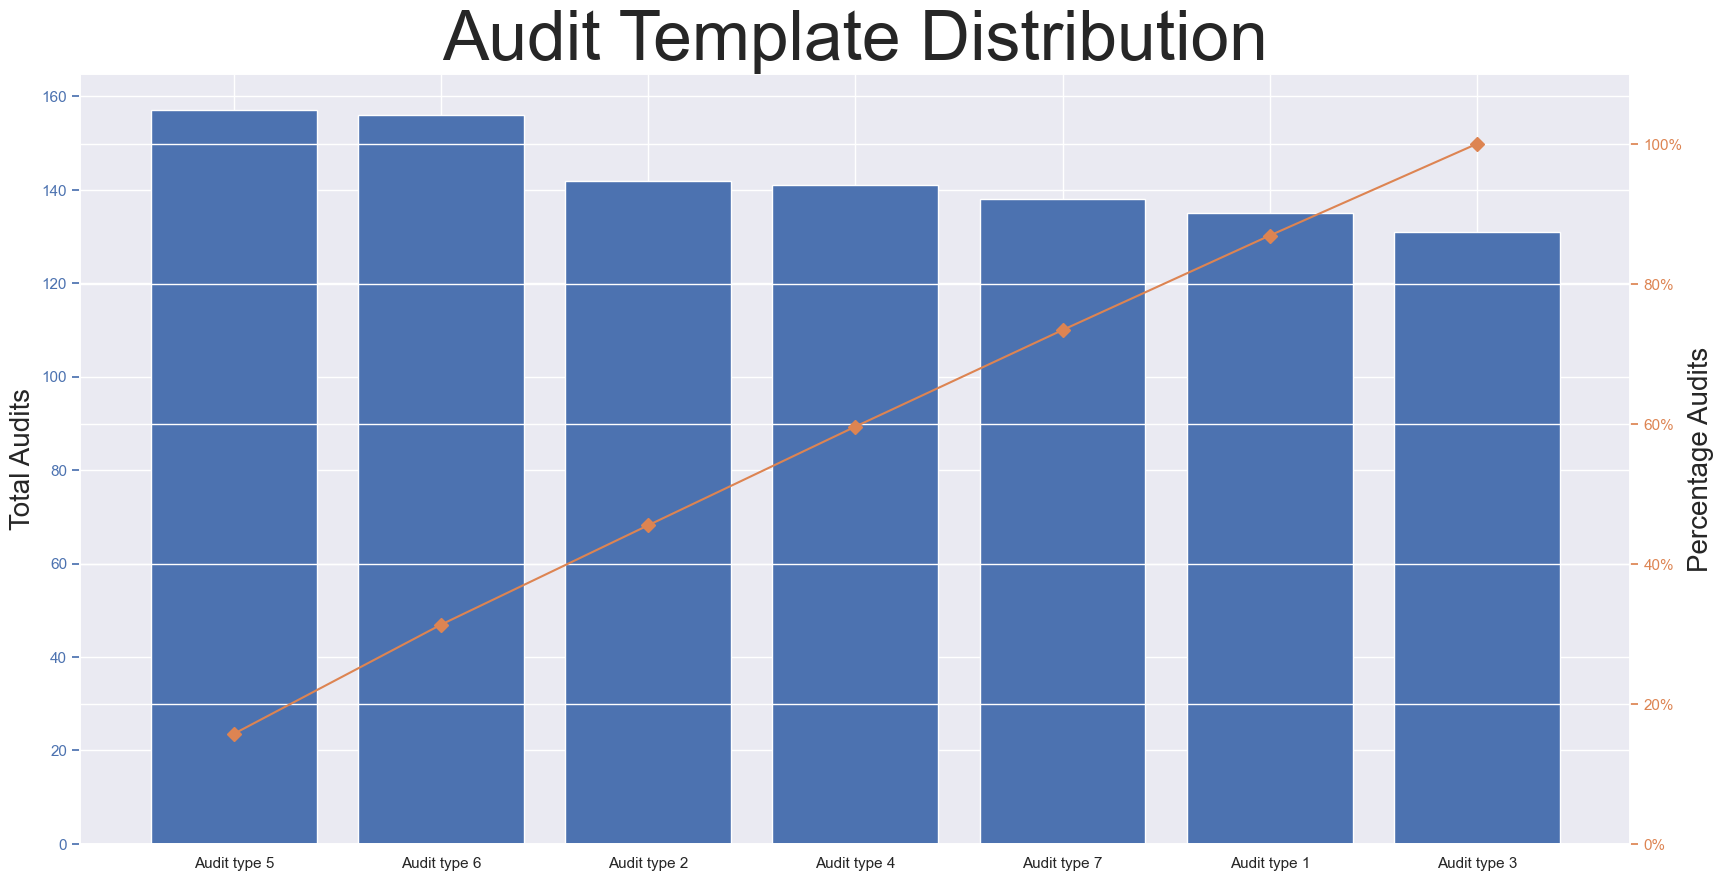

In [926]:
from matplotlib.ticker import PercentFormatter
at_group = dataframeCB.groupby(['AuditTemplate']).count()
at_group['AuditTemplate'] = at_group.index
at_group = at_group[['AuditTemplate','CBID']]
at_group = at_group.reset_index(drop=True)
at_group = at_group.rename(columns={'CBID':'TotalAudits'})

at_group = at_group.sort_values(by='TotalAudits',ascending=False)
at_group["AGGpercentage"] = at_group["TotalAudits"].cumsum()/at_group["TotalAudits"].sum()*100


fig, ax = plt.subplots(figsize= (20,10))
ax.bar(at_group['AuditTemplate'], at_group["TotalAudits"], color="C0")
ax.set_ylabel('Total Audits', fontsize = 20)
ax2 = ax.twinx()
ax2.plot(at_group['AuditTemplate'], at_group["AGGpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylim([0,110])
ax2.set_ylabel('Percentage Audits', fontsize = 20)

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.title('Audit Template Distribution', fontsize = 50)


plt.show()

In [927]:
at_group

,AuditTemplate,TotalAudits,AGGpercentage
4,Audit type 5,157,15.7
5,Audit type 6,156,31.3
1,Audit type 2,142,45.5
3,Audit type 4,141,59.6
6,Audit type 7,138,73.4
0,Audit type 1,135,86.9
2,Audit type 3,131,100.0


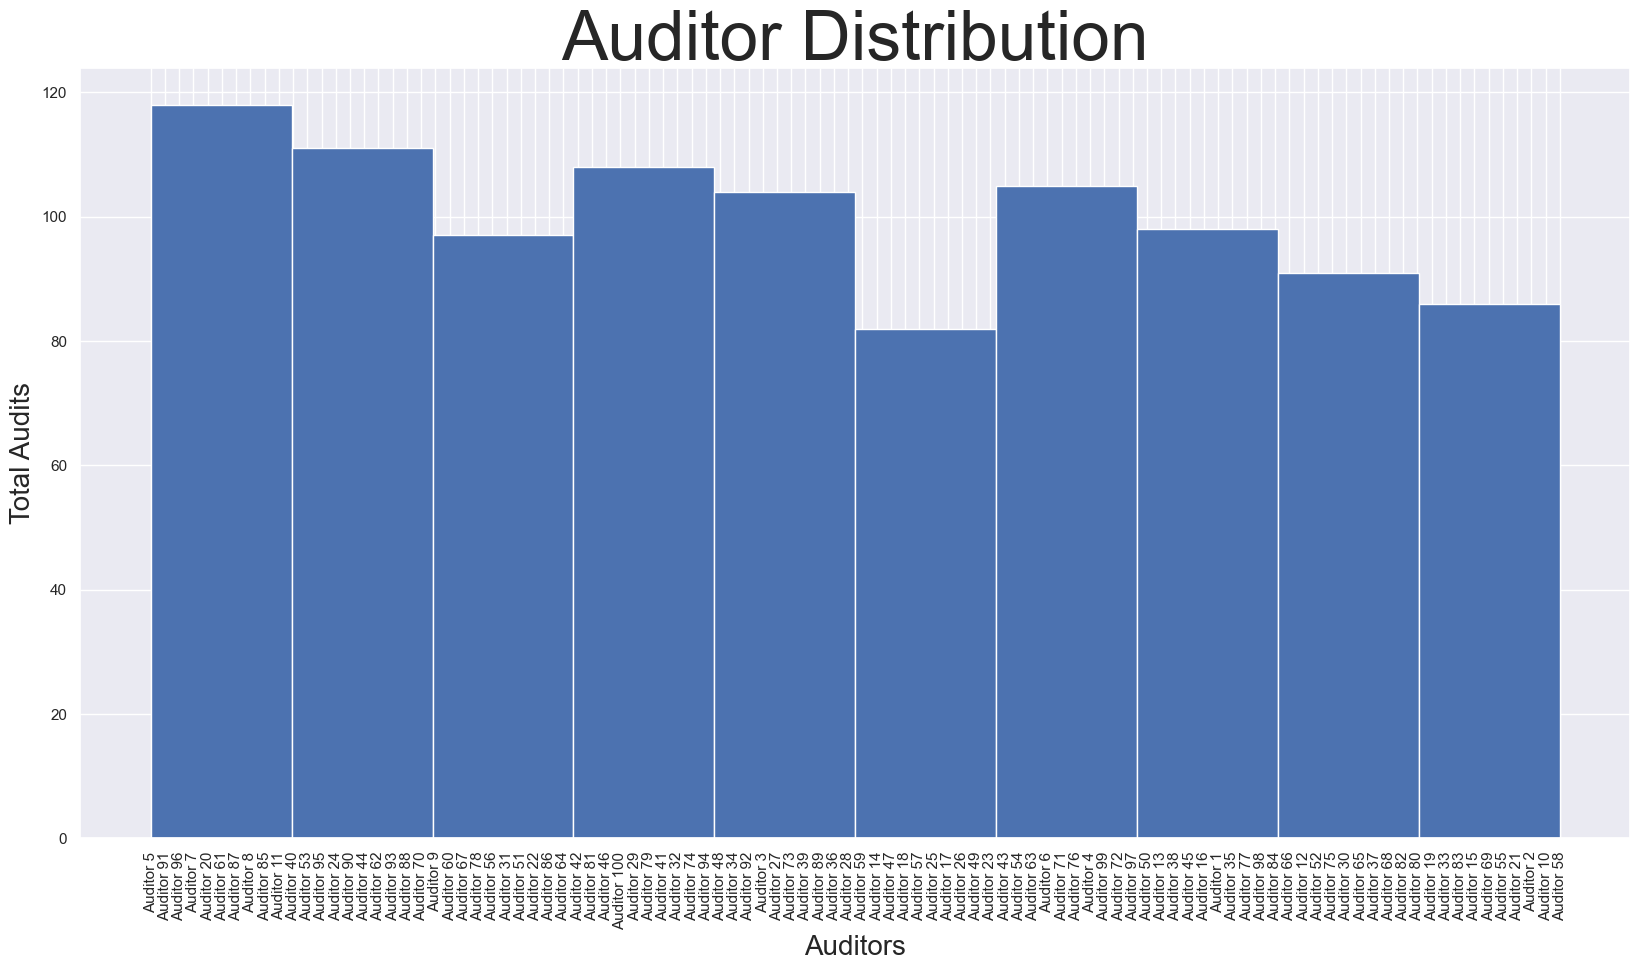

In [928]:
ax1 = plt.figure(figsize= (20,10))

Auditor_group = dataframeCB.astype({"Auditor": str})
plt.hist(Auditor_group['Auditor'])
plt.title('Auditor Distribution', fontsize = 50)
plt.xlabel('Auditors', fontsize = 20)
plt.xticks(rotation=90)
plt.ylabel('Total Audits', fontsize = 20)

plt.show()

In [929]:
dataframeCB['Auditor'].value_counts()

Auditor
Auditor 20    17
Auditor 6     17
Auditor 15    16
Auditor 40    16
Auditor 72    15
              ..
Auditor 10     5
Auditor 43     5
Auditor 14     4
Auditor 55     4
Auditor 21     4
Name: count, Length: 100, dtype: int64

In [930]:
df = dataframe
df['year'] = pd.DatetimeIndex(df['AuditDate']).year
df = df[df['year']==Year]
lastYear = Year - 1
df_2 = dataframe[dataframe['year']==lastYear]
#df['AuditTemplate'].value_counts()

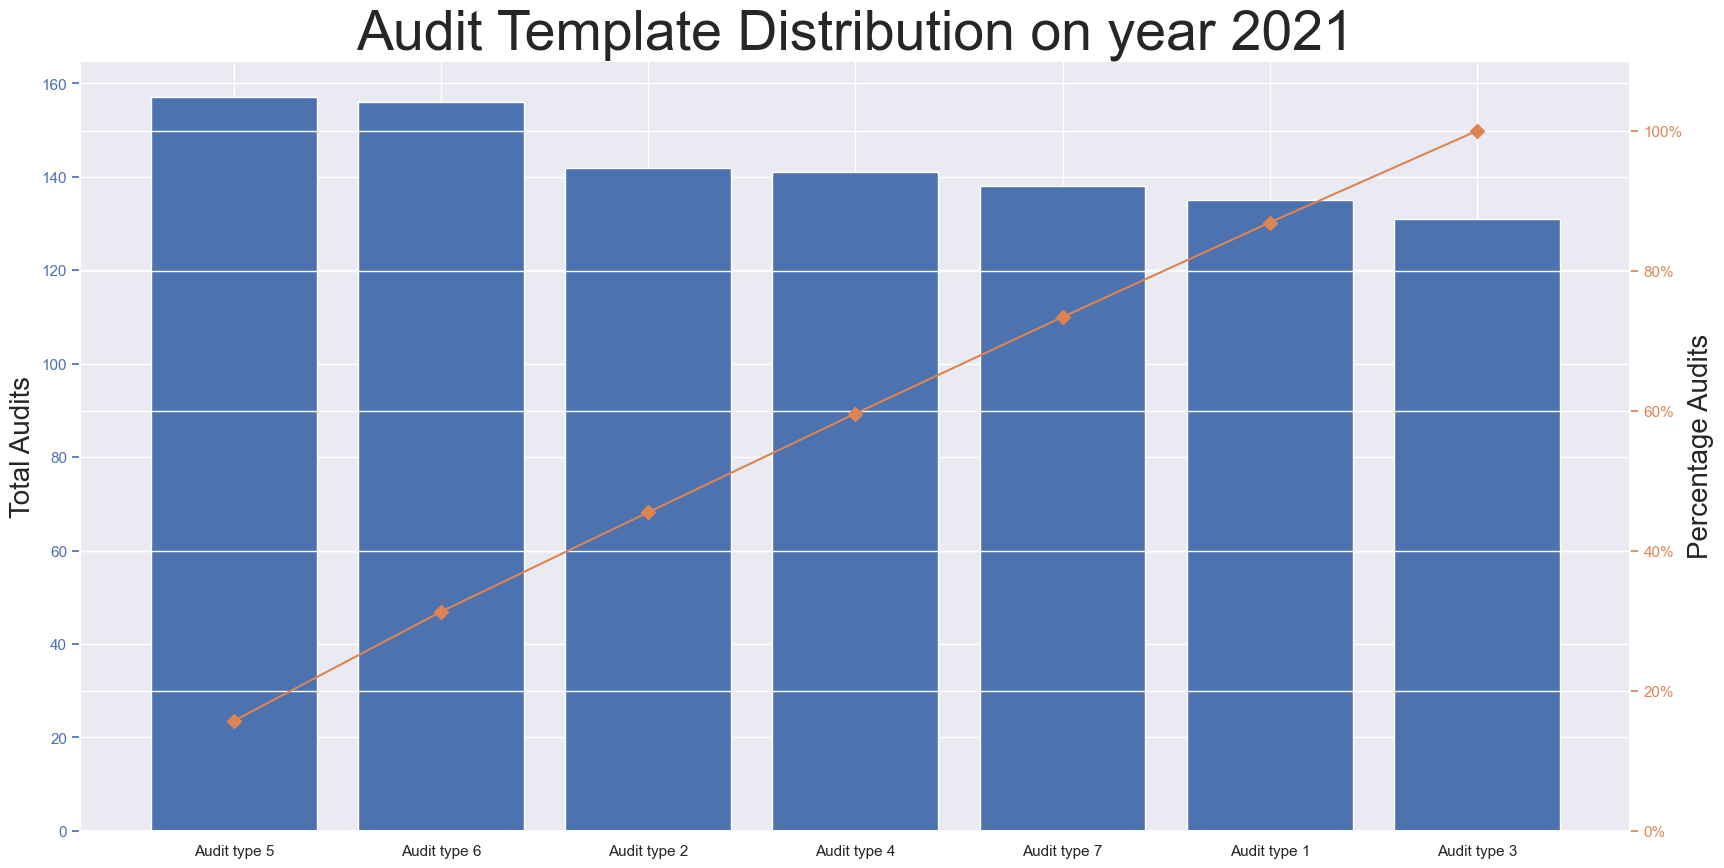

In [931]:
dfCB = dataframeCB
at_group = dfCB.groupby(['AuditTemplate']).count()
at_group['AuditTemplate'] = at_group.index
at_group = at_group[['AuditTemplate','CBID']]
at_group = at_group.reset_index(drop=True)
at_group = at_group.rename(columns={'CBID':'TotalAudits'})

at_group = at_group.sort_values(by='TotalAudits',ascending=False)
at_group["AGGpercentage"] = at_group["TotalAudits"].cumsum()/at_group["TotalAudits"].sum()*100


fig, ax = plt.subplots(figsize= (20,10))
ax.bar(at_group['AuditTemplate'], at_group["TotalAudits"], color="C0")
ax.set_ylabel('Total Audits', fontsize = 20)
ax2 = ax.twinx()
ax2.plot(at_group['AuditTemplate'], at_group["AGGpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylim([0,110])
ax2.set_ylabel('Percentage Audits', fontsize = 20)

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.title('Audit Template Distribution on year ' + str(Year), fontsize = 40)


plt.show()

In [932]:
at_group

,AuditTemplate,TotalAudits,AGGpercentage
4,Audit type 5,157,15.7
5,Audit type 6,156,31.3
1,Audit type 2,142,45.5
3,Audit type 4,141,59.6
6,Audit type 7,138,73.4
0,Audit type 1,135,86.9
2,Audit type 3,131,100.0


# KPI 1 and 2

### Low and High Proportion of NC

In [933]:
x = df[['Auditor','AuditTemplate','id','PercentageNC']]
x = x.groupby(['id','Auditor','AuditTemplate']).mean()
x = pd.DataFrame(x) 
x = x.rename(columns={'PercentageNC':'AVG_PercentageNC'})
#x.head()

## Greenhouse

In [934]:
greenhouse = df[df['AuditTemplate'].str.contains("Audit type 1", case=False)]
greenhouse = greenhouse[['Auditor','PercentageNC']]
greenhouse = greenhouse.groupby('Auditor').mean()

### Distribution of Greenhouse Audits

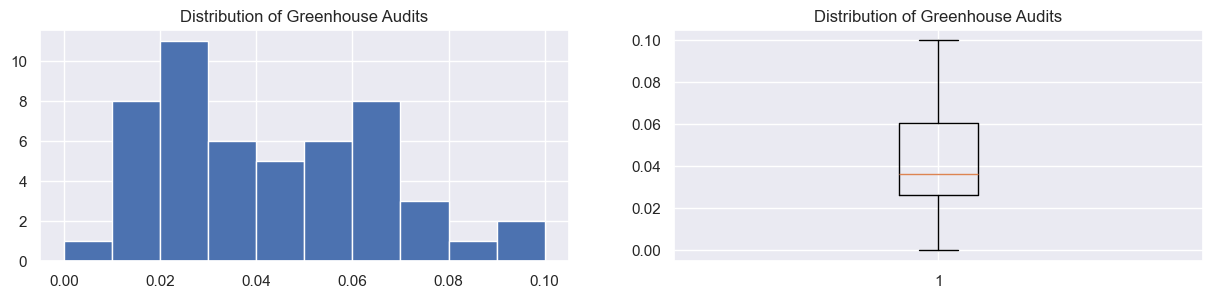

In [935]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(greenhouse['PercentageNC'])
ax1.set_title('Distribution of Greenhouse Audits')
ax2.boxplot(greenhouse['PercentageNC'])
ax2.set_title('Distribution of Greenhouse Audits')

plt.show()

### Calculating KPIs

In [936]:
mean_greenhouse = np.mean(greenhouse.PercentageNC)
q1_gh = np.percentile(greenhouse.PercentageNC, 25)
q2_gh = np.percentile(greenhouse.PercentageNC, 50)
q3_gh = np.percentile(greenhouse.PercentageNC, 75)

IQR_gh = q3_gh - q1_gh

UpperThreshold_gh = q3_gh + HighProportionNC_restriction * IQR_gh
LowerThreshold_gh = q1_gh - LowProportionNC_restriction * IQR_gh
if LowerThreshold_gh < 0:
    LowerThreshold_gh = greenhouse['PercentageNC'].min()
else:
    LowerThreshold_gh = LowerThreshold_gh

In [937]:
gh_analyzed = greenhouse
gh_analyzed['UpperThreshold'] = UpperThreshold_gh
gh_analyzed['HighProportionNC'] = ''
gh_analyzed.loc[gh_analyzed['PercentageNC'] > gh_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
gh_analyzed.loc[gh_analyzed['PercentageNC'] <= gh_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [938]:
gh_analyzed['LowProportionNC'] = ''
gh_analyzed['LowerThreshold'] = LowerThreshold_gh
gh_analyzed.loc[gh_analyzed['PercentageNC'] < gh_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
gh_analyzed.loc[gh_analyzed['PercentageNC'] >= gh_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [939]:
low_gh = gh_analyzed['LowProportionNC']
high_gh = gh_analyzed['HighProportionNC']
gh_analyzed = pd.merge(low_gh, high_gh, on='Auditor', suffixes=('_1', '_2'))
#gh_analyzed.head()

### Visualization of KPI

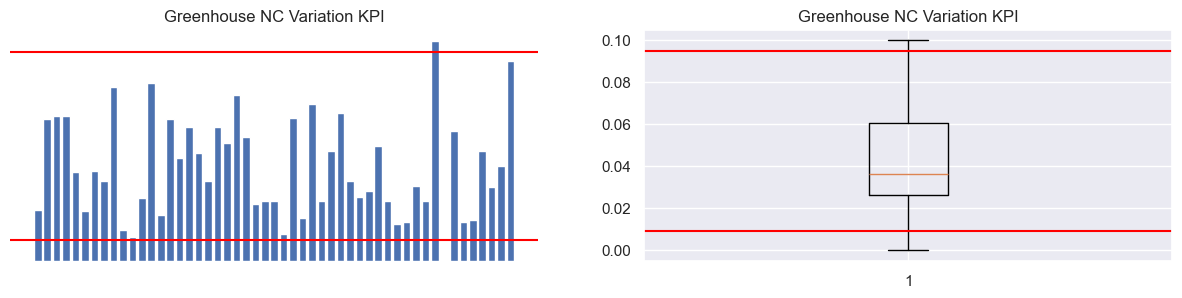

In [940]:
gh2 = greenhouse
gh2['Auditor'] = greenhouse.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(gh2.Auditor,gh2.PercentageNC)
ax1.set_xlabel('Auditors', size = 13,)
ax1.set_ylabel('Mean ProportionNC', size = 13,)
ax1.set_title('Greenhouse NC Variation KPI')
ax1.axhline(y=UpperThreshold_gh, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_gh, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(gh2['PercentageNC'])
ax2.set_title('Greenhouse NC Variation KPI')
ax2.axhline(y=UpperThreshold_gh, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_gh, xmin=0, color = 'red')

plt.show() 

In [941]:
#greenhouse[['PercentageNC','UpperThreshold','HighProportionNC','LowerThreshold','LowProportionNC']]

In [942]:
#greenhouse[['PercentageNC','UpperThreshold','HighProportionNC','LowerThreshold','LowProportionNC']]
mark_gh = greenhouse[(greenhouse.HighProportionNC == 1) | (greenhouse.LowProportionNC) == 1] == True
#mark_gh[['HighProportionNC','LowProportionNC']]

## Ranch

In [943]:
ranch = df[df['AuditTemplate'].str.contains("Audit type 2", case=False)]
ranch = ranch[['Auditor','PercentageNC']]
ranch = ranch.groupby('Auditor').mean()

### Distribution of Ranch's Audits

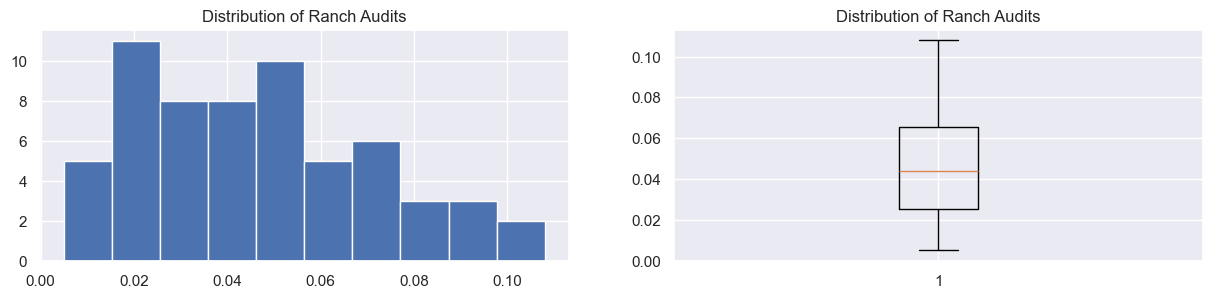

In [944]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(ranch['PercentageNC'])
ax1.set_title('Distribution of Ranch Audits')
ax2.boxplot(ranch['PercentageNC'])
ax2.set_title('Distribution of Ranch Audits')

plt.show()

### Calculating KPIs

In [945]:
mean_ranch = np.mean(ranch.PercentageNC)
q1_rch = np.percentile(ranch.PercentageNC, 25)
q2_rch = np.percentile(ranch.PercentageNC, 50)
q3_rch = np.percentile(ranch.PercentageNC, 75)

IQR_rch = q3_rch - q1_rch

UpperThreshold_rch = q3_rch + HighProportionNC_restriction * IQR_rch
LowerThreshold_rch = q1_rch - LowProportionNC_restriction * IQR_rch
if LowerThreshold_rch < 0:
    LowerThreshold_rch = ranch['PercentageNC'].min()
else:
    LowerThreshold_rch = LowerThreshold_rch

In [946]:
rch_analyzed = ranch
rch_analyzed['UpperThreshold'] = UpperThreshold_rch
rch_analyzed['HighProportionNC'] = ''
rch_analyzed.loc[rch_analyzed['PercentageNC'] > rch_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
rch_analyzed.loc[rch_analyzed['PercentageNC'] <= rch_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [947]:
rch_analyzed['LowProportionNC'] = ''
rch_analyzed['LowerThreshold'] = LowerThreshold_rch
rch_analyzed.loc[rch_analyzed['PercentageNC'] < rch_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
rch_analyzed.loc[rch_analyzed['PercentageNC'] >= rch_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [948]:
low_rch = rch_analyzed['LowProportionNC']
high_rch = rch_analyzed['HighProportionNC']
rch_analyzed = pd.merge(low_rch, high_rch, on='Auditor', suffixes=('_1', '_2'))
#rch_analyzed.head()

### Visualization of KPI

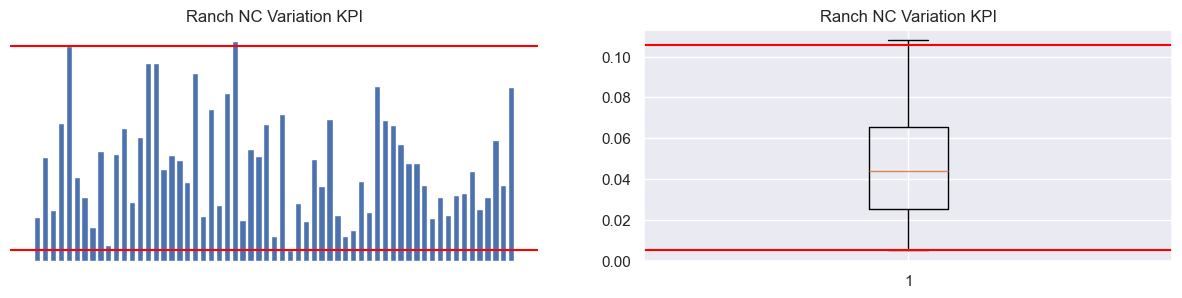

In [949]:
rch2 = ranch
rch2['Auditor'] = ranch.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(rch2.Auditor,rch2.PercentageNC)
ax1.set_title('Ranch NC Variation KPI')
ax1.axhline(y=UpperThreshold_rch, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_rch, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(rch2['PercentageNC'])
ax2.set_title('Ranch NC Variation KPI')
ax2.axhline(y=UpperThreshold_rch, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_rch, xmin=0, color = 'red')

plt.show() 

In [950]:
#ranch[['PercentageNC','UpperThreshold','HighProportionNC','LowerThreshold','LowProportionNC']]
mark_rch = ranch[(ranch.HighProportionNC == 1) | (ranch.LowProportionNC) == 1] == True
#mark_rch[['HighProportionNC','LowProportionNC']]

## Cooling and Cold Storage

In [951]:
cold = df[df['AuditTemplate'].str.contains("Audit type 3", case=False)]
cold = cold[['Auditor','PercentageNC']]
cold = cold.groupby('Auditor').mean()

### Distribution of Cooling and Cold Storage Audits

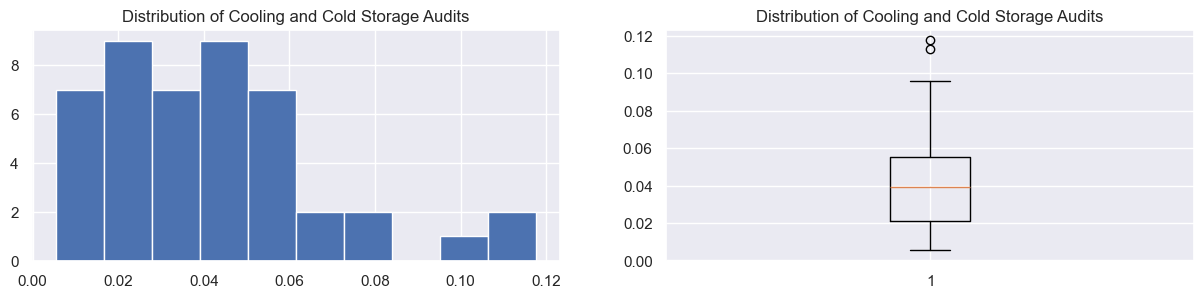

In [952]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(cold['PercentageNC'])
ax1.set_title('Distribution of Cooling and Cold Storage Audits')
ax2.boxplot(cold['PercentageNC'])
ax2.set_title('Distribution of Cooling and Cold Storage Audits')

plt.show()

### Calculating KPIs

In [953]:
mean_cold = np.mean(cold.PercentageNC)
q1_cld = np.percentile(cold.PercentageNC, 25)
q2_cld = np.percentile(cold.PercentageNC, 50)
q3_cld = np.percentile(cold.PercentageNC, 75)

IQR_cld = q3_cld - q1_cld

UpperThreshold_cld = q3_cld + HighProportionNC_restriction * IQR_cld
LowerThreshold_cld = q1_cld - LowProportionNC_restriction * IQR_cld
if LowerThreshold_cld < 0:
    LowerThreshold_cld = cold['PercentageNC'].min()
else:
    LowerThreshold_cld = LowerThreshold_cld

In [954]:
cld_analyzed = cold
cld_analyzed['UpperThreshold'] = UpperThreshold_cld
cld_analyzed['HighProportionNC'] = ''
cld_analyzed.loc[cld_analyzed['PercentageNC'] > cld_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
cld_analyzed.loc[cld_analyzed['PercentageNC'] <= cld_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [955]:
cld_analyzed['LowProportionNC'] = ''
cld_analyzed['LowerThreshold'] = LowerThreshold_cld
cld_analyzed.loc[cld_analyzed['PercentageNC'] < cld_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
cld_analyzed.loc[cld_analyzed['PercentageNC'] >= cld_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [956]:
low_cld = cld_analyzed['LowProportionNC']
high_cld = cld_analyzed['HighProportionNC']
cld_analyzed = pd.merge(low_cld, high_cld, on='Auditor', suffixes=('_1', '_2'))
#cld_analyzed.head()

### Visualization of KPI

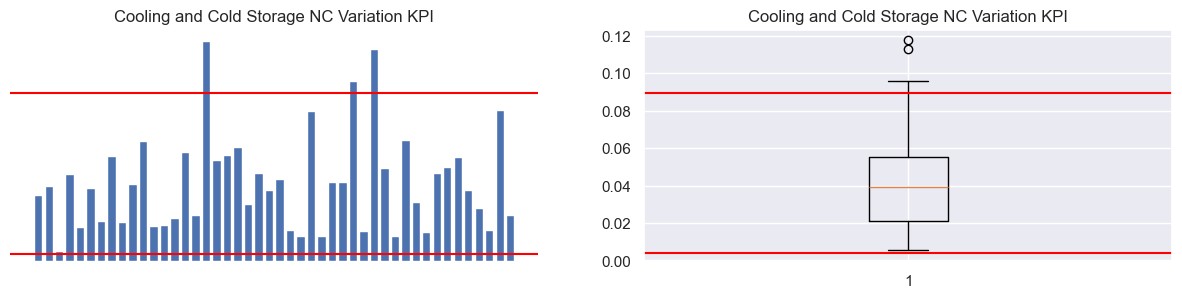

In [957]:
cld2 = cold
cld2['Auditor'] = cold.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(cld2.Auditor,cld2.PercentageNC)
ax1.set_title('Cooling and Cold Storage NC Variation KPI')
ax1.axhline(y=UpperThreshold_cld, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_cld, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(cld2['PercentageNC'])
ax2.set_title('Cooling and Cold Storage NC Variation KPI')
ax2.axhline(y=UpperThreshold_cld, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_cld, xmin=0, color = 'red')

plt.show()  

In [958]:
#cold[['PercentageNC','UpperThreshold','HighProportionNC','LowerThreshold','LowProportionNC']]
mark_cld = cold[(cold.HighProportionNC == 1) | (cold.LowProportionNC) == 1] == True
#mark_cld[['HighProportionNC','LowProportionNC']]

## Harvest Crew

In [959]:
harvc = df[df['AuditTemplate'].str.contains("Audit type 4", case=False)]
harvc = harvc[['Auditor','PercentageNC']]
harvc = harvc.groupby('Auditor').mean()

### Distribution of Harvest Crew's Audits

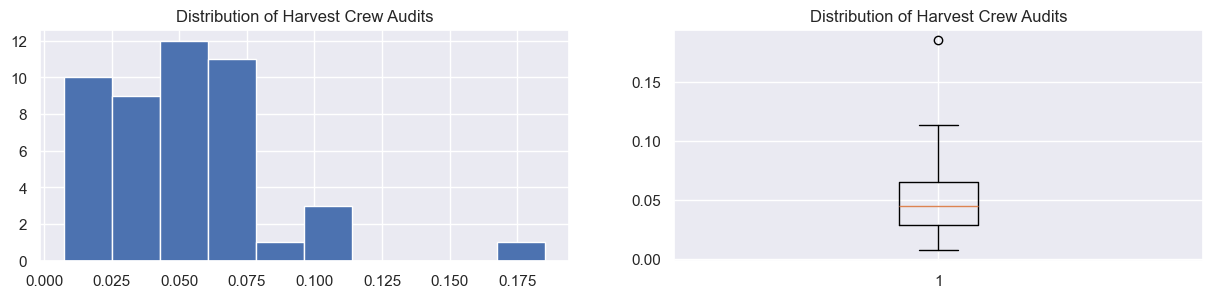

In [960]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(harvc['PercentageNC'])
ax1.set_title('Distribution of Harvest Crew Audits')
ax2.boxplot(harvc['PercentageNC'])
ax2.set_title('Distribution of Harvest Crew Audits')

plt.show()

### Calculating KPIs

In [961]:
mean_harvc = np.mean(harvc.PercentageNC)
q1_hc = np.percentile(harvc.PercentageNC, 25)
q2_hc = np.percentile(harvc.PercentageNC, 50)
q3_hc = np.percentile(harvc.PercentageNC, 75)

IQR_hc = q3_hc - q1_hc

UpperThreshold_hc = q3_hc + HighProportionNC_restriction * IQR_hc
LowerThreshold_hc = q1_hc - LowProportionNC_restriction * IQR_hc
if LowerThreshold_hc < 0:
    LowerThreshold_hc = harvc['PercentageNC'].min()
else:
    LowerThreshold_hc = LowerThreshold_hc

In [962]:
hc_analyzed = harvc
hc_analyzed['UpperThreshold'] = UpperThreshold_hc
hc_analyzed['HighProportionNC'] = ''
hc_analyzed.loc[hc_analyzed['PercentageNC'] > hc_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
hc_analyzed.loc[hc_analyzed['PercentageNC'] <= hc_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [963]:
hc_analyzed['LowProportionNC'] = ''
hc_analyzed['LowerThreshold'] = LowerThreshold_hc
hc_analyzed.loc[hc_analyzed['PercentageNC'] < hc_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
hc_analyzed.loc[hc_analyzed['PercentageNC'] >= hc_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [964]:
low_hc = hc_analyzed['LowProportionNC']
high_hc = hc_analyzed['HighProportionNC']
hc_analyzed = pd.merge(low_hc, high_hc, on='Auditor', suffixes=('_1', '_2'))
#hc_analyzed.head()

### Visualization of KPI

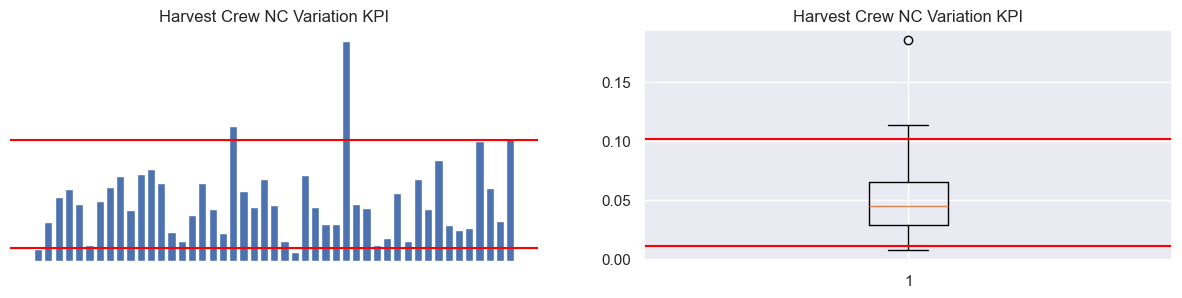

In [965]:
hc2 = harvc
hc2['Auditor'] = harvc.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(hc2.Auditor,hc2.PercentageNC)
ax1.set_title('Harvest Crew NC Variation KPI')
ax1.axhline(y=UpperThreshold_hc, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_hc, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(hc2['PercentageNC'])
ax2.set_title('Harvest Crew NC Variation KPI')
ax2.axhline(y=UpperThreshold_hc, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_hc, xmin=0, color = 'red')

plt.show()  

In [966]:
#harvc[['PercentageNC','UpperThreshold','HighProportionNC','LowerThreshold','LowProportionNC']]
mark_hc = harvc[(harvc.HighProportionNC == 1) | (harvc.LowProportionNC) == 1] == True
#mark_hc[['HighProportionNC','LowProportionNC']]

## Packinghouse

In [967]:
packinghouse = df[df['AuditTemplate'].str.contains("Audit type 5", case=False)]
packinghouse = packinghouse[['Auditor','PercentageNC']]
packinghouse = packinghouse.groupby('Auditor').mean()

### Distribution of Packinghouse's Audits

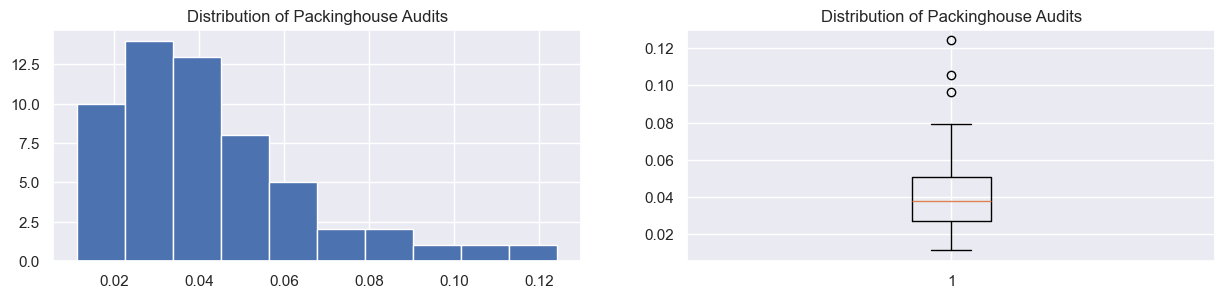

In [968]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(packinghouse['PercentageNC'])
ax1.set_title('Distribution of Packinghouse Audits')
ax2.boxplot(packinghouse['PercentageNC'])
ax2.set_title('Distribution of Packinghouse Audits')

plt.show()

### Calculating KPIs

In [969]:
mean_packinghouse = np.mean(packinghouse.PercentageNC)
q1_pkh = np.percentile(packinghouse.PercentageNC, 25)
q2_pkh = np.percentile(packinghouse.PercentageNC, 50)
q3_pkh = np.percentile(packinghouse.PercentageNC, 75)

IQR_pkh = q3_pkh - q1_pkh

UpperThreshold_pkh = q3_pkh + HighProportionNC_restriction * IQR_pkh
LowerThreshold_pkh = q1_pkh - LowProportionNC_restriction * IQR_pkh
if LowerThreshold_pkh < 0:
    LowerThreshold_pkh = packinghouse['PercentageNC'].min()
else:
    LowerThreshold_pkh = LowerThreshold_pkh

In [970]:
pkh_analyzed = packinghouse
pkh_analyzed['UpperThreshold'] = UpperThreshold_pkh
pkh_analyzed['HighProportionNC'] = ''
pkh_analyzed.loc[pkh_analyzed['PercentageNC'] > pkh_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
pkh_analyzed.loc[pkh_analyzed['PercentageNC'] <= pkh_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [971]:
pkh_analyzed['LowProportionNC'] = ''
pkh_analyzed['LowerThreshold'] = LowerThreshold_pkh
pkh_analyzed.loc[pkh_analyzed['PercentageNC'] < pkh_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
pkh_analyzed.loc[pkh_analyzed['PercentageNC'] >= pkh_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [972]:
low_pkh = pkh_analyzed['LowProportionNC']
high_pkh = pkh_analyzed['HighProportionNC']
pkh_analyzed = pd.merge(low_pkh, high_pkh, on='Auditor', suffixes=('_1', '_2'))
#pkh_analyzed.head()

### Visualization of KPI

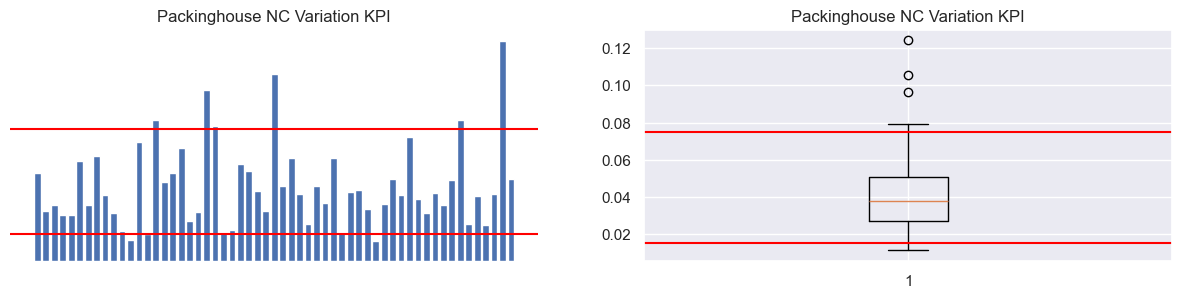

In [973]:
pkh2 = packinghouse
pkh2['Auditor'] = packinghouse.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(pkh2.Auditor,pkh2.PercentageNC)
ax1.set_title('Packinghouse NC Variation KPI')
ax1.axhline(y=UpperThreshold_pkh, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_pkh, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(pkh2['PercentageNC'])
ax2.set_title('Packinghouse NC Variation KPI')
ax2.axhline(y=UpperThreshold_pkh, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_pkh, xmin=0, color = 'red')

plt.show()  

In [974]:
#packinghouse[['PercentageNC','UpperThreshold','HighProportionNC','LowerThreshold','LowProportionNC']]
mark_pkh = packinghouse[(packinghouse.HighProportionNC == 1) | (packinghouse.LowProportionNC) == 1] == True
#mark_pkh[['HighProportionNC','LowProportionNC']]

## Packaging

In [975]:
packaging = df[df['AuditTemplate'].str.contains("Audit type 6", case=False)]
packaging = packaging[['Auditor','PercentageNC']]
packaging = packaging.groupby('Auditor').mean()

### Distribution of Packaging's Audits

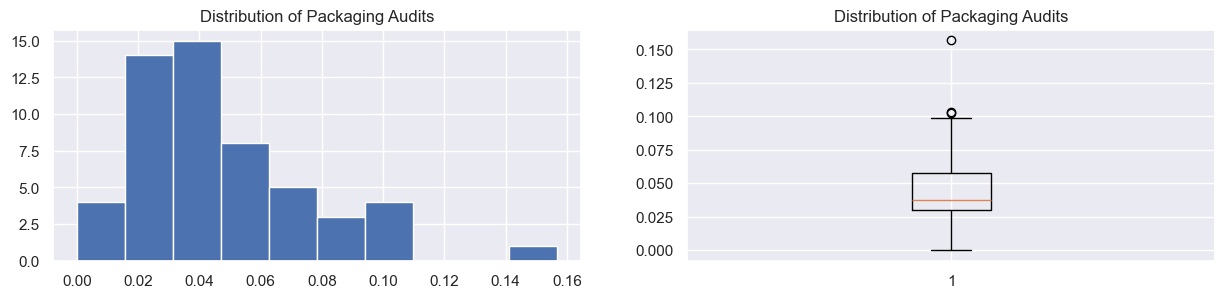

In [976]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(packaging['PercentageNC'])
ax1.set_title('Distribution of Packaging Audits')
ax2.boxplot(packaging['PercentageNC'])
ax2.set_title('Distribution of Packaging Audits')

plt.show()

### Calculating KPIs

In [977]:
mean_packaging = np.mean(packaging.PercentageNC)
q1_pk = np.percentile(packaging.PercentageNC, 25)
q2_pk = np.percentile(packaging.PercentageNC, 50)
q3_pk = np.percentile(packaging.PercentageNC, 75)

IQR_pk = q3_pk - q1_pk

UpperThreshold_pk = q3_pk + HighProportionNC_restriction * IQR_pk
LowerThreshold_pk = q1_pk - LowProportionNC_restriction * IQR_pk
if LowerThreshold_pk < 0:
    LowerThreshold_pk = packaging['PercentageNC'].min()
else:
    LowerThreshold_pk = LowerThreshold_pk

In [978]:
pk_analyzed = packaging
pk_analyzed['UpperThreshold'] = UpperThreshold_pk
pk_analyzed['HighProportionNC'] = ''
pk_analyzed.loc[pk_analyzed['PercentageNC'] > pk_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
pk_analyzed.loc[pk_analyzed['PercentageNC'] <= pk_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [979]:
pk_analyzed['LowProportionNC'] = ''
pk_analyzed['LowerThreshold'] = LowerThreshold_pk
pk_analyzed.loc[pk_analyzed['PercentageNC'] < pk_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
pk_analyzed.loc[pk_analyzed['PercentageNC'] >= pk_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [980]:
low_pk = pk_analyzed['LowProportionNC']
high_pk = pk_analyzed['HighProportionNC']
pk_analyzed = pd.merge(low_pk, high_pk, on='Auditor', suffixes=('_1', '_2'))
#pk_analyzed.head()

### Visualization of KPI

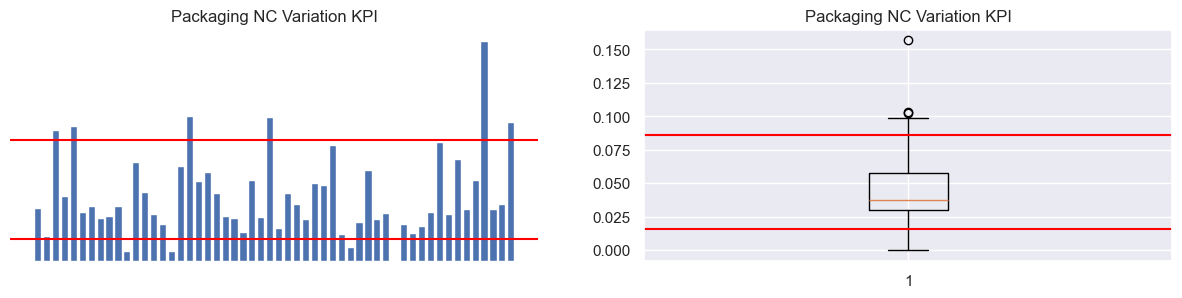

In [981]:
pk2 = packaging
pk2['Auditor'] = packaging.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(pk2.Auditor,pk2.PercentageNC)
ax1.set_title('Packaging NC Variation KPI')
ax1.axhline(y=UpperThreshold_pk, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_pk, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(pk2['PercentageNC'])
ax2.set_title('Packaging NC Variation KPI')
ax2.axhline(y=UpperThreshold_pk, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_pk, xmin=0, color = 'red')

plt.show()  

In [982]:
#packaging[['PercentageNC','UpperThreshold','HighProportionNC','LowerThreshold','LowProportionNC']]
mark_pk = packaging[(packaging.HighProportionNC == 1) | (packaging.LowProportionNC) == 1] == True
#mark_pk[['HighProportionNC','LowProportionNC']]

## Storage & Distribution Center

In [983]:
storage = df[df['AuditTemplate'].str.contains("Audit type 7", case=False)]
storage = storage[['Auditor','PercentageNC']]
storage = storage.groupby('Auditor').mean()

### Distribution of Storage & Distribution Center's Audits

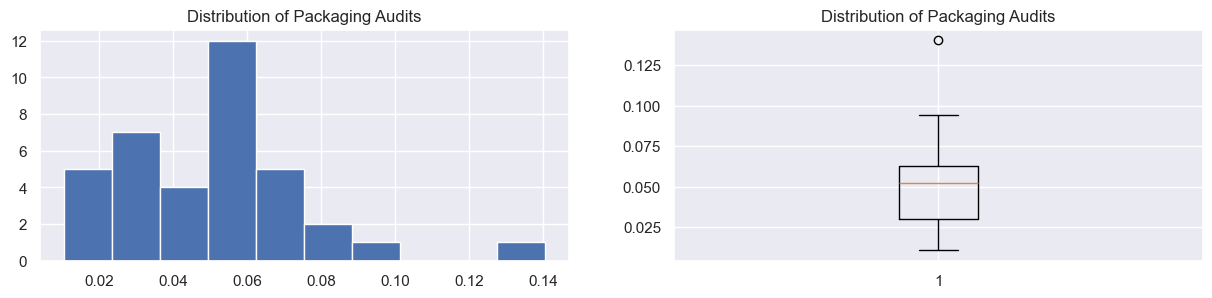

In [984]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(storage['PercentageNC'])
ax1.set_title('Distribution of Packaging Audits')
ax2.boxplot(storage['PercentageNC'])
ax2.set_title('Distribution of Packaging Audits')

plt.show()

### Calculating KPI

In [985]:
mean_storage = np.mean(storage.PercentageNC)
q1_sd = np.percentile(storage.PercentageNC, 25)
q2_sd = np.percentile(storage.PercentageNC, 50)
q3_sd = np.percentile(storage.PercentageNC, 75)

IQR_sd = q3_sd - q1_sd

UpperThreshold_sd = q3_sd + HighProportionNC_restriction * IQR_sd
LowerThreshold_sd = q1_sd - LowProportionNC_restriction * IQR_sd
if LowerThreshold_sd < 0:
    LowerThreshold_sd = storage['PercentageNC'].min()
else:
    LowerThreshold_sd = LowerThreshold_sd

In [986]:
sd_analyzed = storage
sd_analyzed['UpperThreshold'] = UpperThreshold_sd
sd_analyzed['HighProportionNC'] = ''
sd_analyzed.loc[sd_analyzed['PercentageNC'] > sd_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
sd_analyzed.loc[sd_analyzed['PercentageNC'] <= sd_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [987]:
sd_analyzed['LowProportionNC'] = ''
sd_analyzed['LowerThreshold'] = LowerThreshold_sd
sd_analyzed.loc[sd_analyzed['PercentageNC'] < sd_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
sd_analyzed.loc[sd_analyzed['PercentageNC'] >= sd_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [988]:
low_sd = sd_analyzed['LowProportionNC']
high_sd = sd_analyzed['HighProportionNC']
sd_analyzed = pd.merge(low_sd, high_sd, on='Auditor', suffixes=('_1', '_2'))
#sd_analyzed.head()

### Visualization of KPI

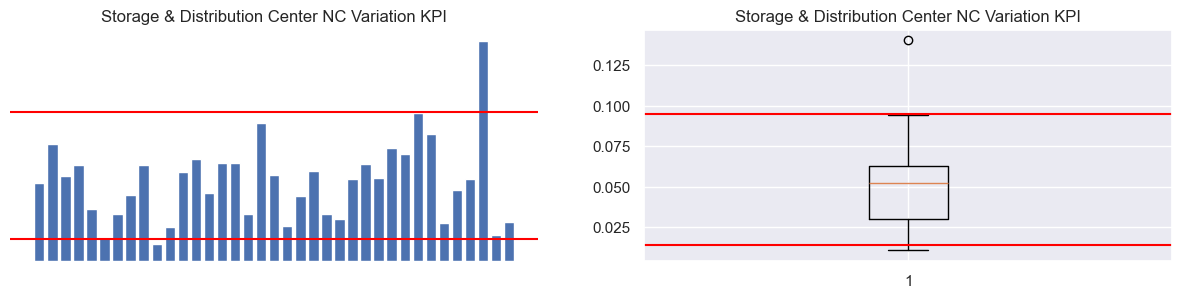

In [989]:
sd2 = storage
sd2['Auditor'] = storage.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(sd2.Auditor,sd2.PercentageNC)
ax1.set_title('Storage & Distribution Center NC Variation KPI')
ax1.axhline(y=UpperThreshold_sd, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_sd, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(sd2['PercentageNC'])
ax2.set_title('Storage & Distribution Center NC Variation KPI')
ax2.axhline(y=UpperThreshold_sd, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_sd, xmin=0, color = 'red')

plt.show()  

In [990]:
#storage[['PercentageNC','UpperThreshold','HighProportionNC','LowerThreshold','LowProportionNC']]
mark_sd = storage[(storage.HighProportionNC == 1) | (storage.LowProportionNC) == 1] == True
#mark_sd[['HighProportionNC','LowProportionNC']]

# KPI 3 and 4

## Low and High Variation of NC

In [991]:
y = df[['Auditor','AuditTemplate','id','PercentageNC']]
y = y.groupby(['Auditor','AuditTemplate','id']).std()
y = pd.DataFrame(y) 
y = y.rename(columns={'PercentageNC':'STD_PercentageNC'})
#y

In [992]:
y = df[['Auditor','AuditTemplate','id','PercentageNC']]
y = y.groupby(['id','Auditor','AuditTemplate']).std()
y = pd.DataFrame(y) 
y = y.rename(columns={'PercentageNC':'STD_PercentageNC'})
#y.head()

## Greenhouse

In [993]:
greenhouseSTD = df[df['AuditTemplate'].str.contains("Audit type 1", case=False)]
greenhouseSTD = greenhouseSTD[['Auditor','PercentageNC']]
greenhouseSTD = greenhouseSTD.groupby('Auditor').std()
greenhouseSTD = greenhouseSTD.rename(columns={'PercentageNC':'StdNC'})
greenhouseSTD = greenhouseSTD.dropna()
#greenhouseSTD

### Distribution of Variance of NC  

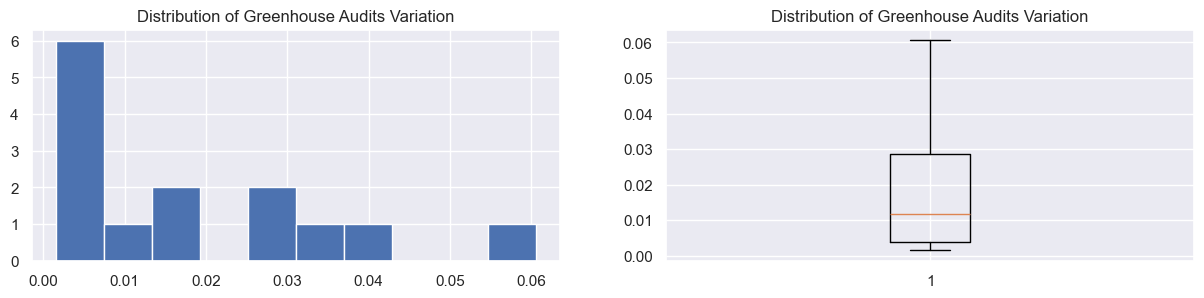

In [994]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(greenhouseSTD['StdNC'])
ax1.set_title('Distribution of Greenhouse Audits Variation')
ax2.boxplot(greenhouseSTD['StdNC'])
ax2.set_title('Distribution of Greenhouse Audits Variation')

plt.show()

### Calculating KPI

In [995]:
meanSTD_greenhouse = np.mean(greenhouseSTD.StdNC)
q1_ghs = np.percentile(greenhouseSTD.StdNC, 25)
q2_ghs = np.percentile(greenhouseSTD.StdNC, 50)
q3_ghs = np.percentile(greenhouseSTD.StdNC, 75)

IQR_ghs = q3_ghs - q1_ghs

UpperThreshold_ghs = q3_ghs + HighVariationNC_restriction * IQR_ghs
LowerThreshold_ghs = q1_ghs - LowVariationNC_restriction * IQR_ghs
if LowerThreshold_ghs < 0:
    LowerThreshold_ghs = greenhouseSTD['StdNC'].min()
else:
    LowerThreshold_ghs = LowerThreshold_ghs

In [996]:
ghs_analyzed = greenhouseSTD
ghs_analyzed['UpperThreshold'] = UpperThreshold_ghs
ghs_analyzed['HighProportionNC'] = ''
ghs_analyzed.loc[ghs_analyzed['StdNC'] > ghs_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
ghs_analyzed.loc[ghs_analyzed['StdNC'] <= ghs_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [997]:
ghs_analyzed['LowProportionNC'] = ''
ghs_analyzed['LowerThreshold'] = LowerThreshold_ghs
ghs_analyzed.loc[ghs_analyzed['StdNC'] < ghs_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
ghs_analyzed.loc[ghs_analyzed['StdNC'] >= ghs_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [998]:
low_ghs = ghs_analyzed['LowProportionNC']
high_ghs = ghs_analyzed['HighProportionNC']
ghs_analyzed = pd.merge(low_ghs, high_ghs, on='Auditor', suffixes=('_1', '_2'))
ghs_analyzed = ghs_analyzed.rename(columns={'HighProportionNC':'HighVariationNC','LowProportionNC':'LowVariationNC'})
#ghs_analyzed.head()

### Visualization of KPI

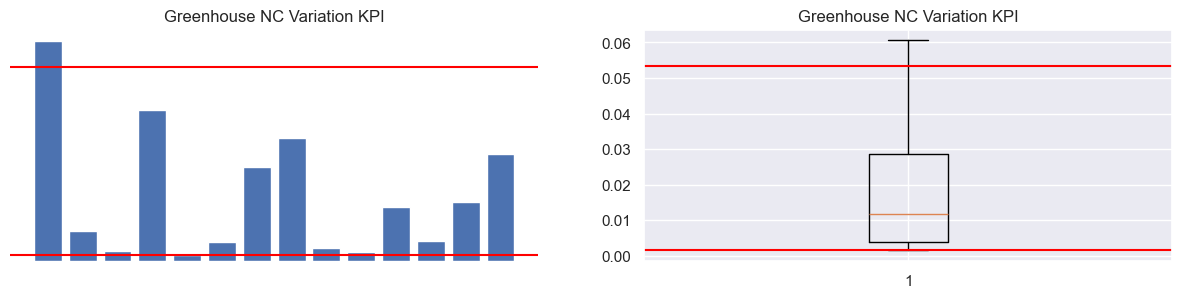

In [999]:
ghs2 = greenhouseSTD
ghs2['Auditor'] = greenhouseSTD.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(ghs2.Auditor,ghs2.StdNC)
ax1.set_title('Greenhouse NC Variation KPI')
ax1.axhline(y=UpperThreshold_ghs, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_ghs, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(ghs2['StdNC'])
ax2.set_title('Greenhouse NC Variation KPI')
ax2.axhline(y=UpperThreshold_ghs, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_ghs, xmin=0, color = 'red')

plt.show()  

In [1000]:
#greenhouseSTD[['StdNC','UpperThreshold','HighVariationNC','LowerThreshold','LowVariationNC']]
greenhouseSTD = greenhouseSTD.rename(columns={'HighProportionNC':'HighVariationNC','LowProportionNC':'LowVariationNC'})
mark_ghs = greenhouseSTD[(greenhouseSTD.HighVariationNC == 1) | (greenhouseSTD.LowVariationNC) == 1] == True
#mark_ghs[['HighVariationNC','LowVariationNC']]

## Ranch

In [1001]:
ranchSTD = df[df['AuditTemplate'].str.contains("Audit type 2", case=False)]
ranchSTD = ranchSTD[['Auditor','PercentageNC']]
ranchSTD = ranchSTD.groupby('Auditor').std()
ranchSTD = ranchSTD.rename(columns={'PercentageNC':'StdNC'})
ranchSTD = ranchSTD.dropna()
#ranchSTD.head()

### Distribution of Variance NC Ranch

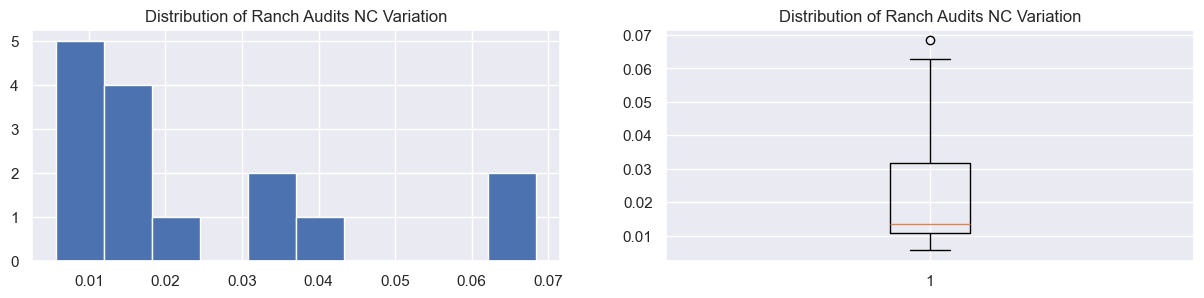

In [1002]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(ranchSTD['StdNC'])
ax1.set_title('Distribution of Ranch Audits NC Variation')
ax2.boxplot(ranchSTD['StdNC'])
ax2.set_title('Distribution of Ranch Audits NC Variation')

plt.show()

### Calculating KPI

In [1003]:
meanSTD_ranch = np.mean(ranchSTD.StdNC)
q1_rhs = np.percentile(ranchSTD.StdNC, 25)
q2_rhs = np.percentile(ranchSTD.StdNC, 50)
q3_rhs = np.percentile(ranchSTD.StdNC, 75)

IQR_rhs = q3_rhs - q1_rhs

UpperThreshold_rhs = q3_rhs + HighVariationNC_restriction * IQR_rhs
LowerThreshold_rhs = q1_rhs - LowVariationNC_restriction * IQR_rhs
if LowerThreshold_rhs < 0:
    LowerThreshold_rhs = ranchSTD['StdNC'].min()
else:
    LowerThreshold_rhs = LowerThreshold_rhs

In [1004]:
rhs_analyzed = ranchSTD
rhs_analyzed['UpperThreshold'] = UpperThreshold_rhs
rhs_analyzed['HighProportionNC'] = ''
rhs_analyzed.loc[rhs_analyzed['StdNC'] > rhs_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
rhs_analyzed.loc[rhs_analyzed['StdNC'] <= rhs_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [1005]:
rhs_analyzed['LowProportionNC'] = ''
rhs_analyzed['LowerThreshold'] = LowerThreshold_rhs
rhs_analyzed.loc[rhs_analyzed['StdNC'] < rhs_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
rhs_analyzed.loc[rhs_analyzed['StdNC'] >= rhs_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [1006]:
low_rhs = rhs_analyzed['LowProportionNC']
high_rhs = rhs_analyzed['HighProportionNC']
rhs_analyzed = pd.merge(low_rhs, high_rhs, on='Auditor', suffixes=('_1', '_2'))
rhs_analyzed = rhs_analyzed.rename(columns={'HighProportionNC':'HighVariationNC','LowProportionNC':'LowVariationNC'})
#rhs_analyzed.head()

### Visualization of KPI

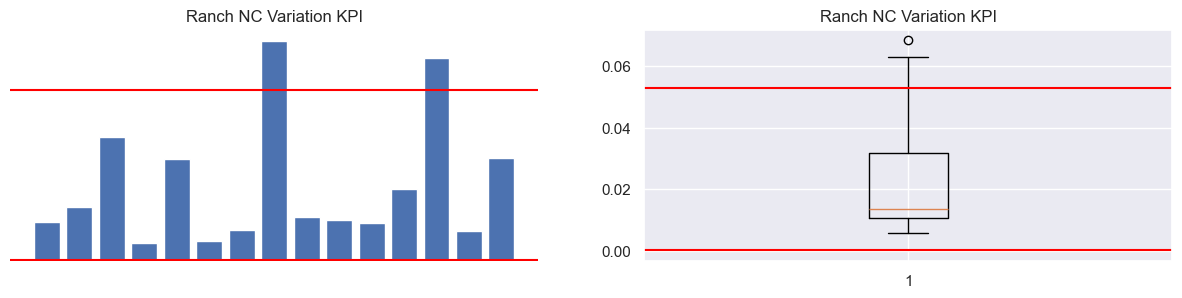

In [1007]:
rhs2 = ranchSTD
rhs2['Auditor'] = ranchSTD.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(rhs2.Auditor,rhs2.StdNC)
ax1.set_title('Ranch NC Variation KPI')
ax1.axhline(y=UpperThreshold_rhs, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_rhs, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(rhs2['StdNC'])
ax2.set_title('Ranch NC Variation KPI')
ax2.axhline(y=UpperThreshold_rhs, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_rhs, xmin=0, color = 'red')

plt.show()  

In [1008]:
#ranchSTD[['StdNC','UpperThreshold','HighVariationNC','LowerThreshold','LowVariationNC']]
ranchSTD = ranchSTD.rename(columns={'HighProportionNC':'HighVariationNC','LowProportionNC':'LowVariationNC'})
mark_rhs = ranchSTD[(ranchSTD.HighVariationNC == 1) | (ranchSTD.LowVariationNC) == 1] == True
#mark_rhs[['HighVariationNC','LowVariationNC']]

## Cooling and Cold Storage

In [1009]:
coldSTD = df[df['AuditTemplate'].str.contains("Audit type 3", case=False)]
coldSTD = coldSTD[['Auditor','PercentageNC']]
coldSTD = coldSTD.groupby('Auditor').std()
coldSTD = coldSTD.rename(columns={'PercentageNC':'StdNC'})
coldSTD = coldSTD.dropna()
#coldSTD.head()

### Distribution of NC Variation Cooling and Cold Storage Audits

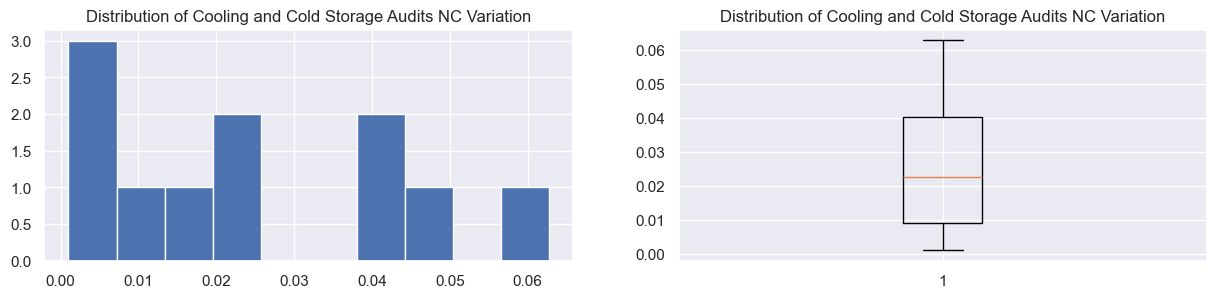

In [1010]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(coldSTD['StdNC'])
ax1.set_title('Distribution of Cooling and Cold Storage Audits NC Variation')
ax2.boxplot(coldSTD['StdNC'])
ax2.set_title('Distribution of Cooling and Cold Storage Audits NC Variation')

plt.show()

### Calculating KPI

In [1011]:
if coldSTD.empty:
    print('DataFrame is empty!')
else:
    meanSTD_cold = np.mean(coldSTD.StdNC)
    q1_cls = np.percentile(coldSTD.StdNC, 25)
    q2_cls = np.percentile(coldSTD.StdNC, 50)
    q3_cls = np.percentile(coldSTD.StdNC, 75)

    IQR_cls = q3_cls - q1_cls

    UpperThreshold_cls = q3_cls + HighVariationNC_restriction * IQR_cls
    LowerThreshold_cls = q1_cls - LowVariationNC_restriction * IQR_cls
    if LowerThreshold_cls < 0:
        LowerThreshold_cls = coldSTD['StdNC'].min()
    else:
        LowerThreshold_cls = LowerThreshold_cls

In [1012]:
if coldSTD.empty:
    print('DataFrame is empty!')
else:    
    cls_analyzed = coldSTD
    cls_analyzed['UpperThreshold'] = UpperThreshold_cls
    cls_analyzed['HighProportionNC'] = ''
    cls_analyzed.loc[cls_analyzed['StdNC'] > cls_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
    cls_analyzed.loc[cls_analyzed['StdNC'] <= cls_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [1013]:
if coldSTD.empty:
    print('DataFrame is empty!')
else:
    cls_analyzed['LowProportionNC'] = ''
    cls_analyzed['LowerThreshold'] = LowerThreshold_cls
    cls_analyzed.loc[cls_analyzed['StdNC'] < cls_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
    cls_analyzed.loc[cls_analyzed['StdNC'] >= cls_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [1014]:
if coldSTD.empty:
    print('DataFrame is empty!')
else:
    low_cls = cls_analyzed['LowProportionNC']
    high_cls = cls_analyzed['HighProportionNC']
    cls_analyzed = pd.merge(low_cls, high_cls, on='Auditor', suffixes=('_1', '_2'))
    #cls_analyzed.head()

### Visualization of KPI

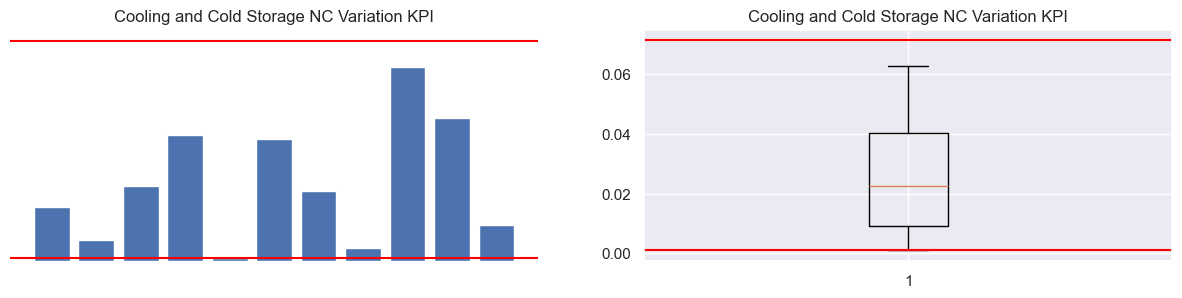

In [1015]:
if coldSTD.empty:
    print('DataFrame is empty!')
else:        
    cls2 = coldSTD
    cls2['Auditor'] = coldSTD.index

    f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
    ax1.bar(cls2.Auditor,cls2.StdNC)
    ax1.set_title('Cooling and Cold Storage NC Variation KPI')
    ax1.axhline(y=UpperThreshold_cls, xmin=0, color = 'red')
    ax1.axhline(y=LowerThreshold_cls, xmin=0, color = 'red')
    ax1.axis('off')
    ax2.boxplot(cls2['StdNC'])
    ax2.set_title('Cooling and Cold Storage NC Variation KPI')
    ax2.axhline(y=UpperThreshold_cls, xmin=0, color = 'red')
    ax2.axhline(y=LowerThreshold_cls, xmin=0, color = 'red')

    plt.show()  

In [1016]:
if coldSTD.empty:
    print('DataFrame is empty!')
else:
    #coldSTD[['StdNC','UpperThreshold','HighVariationNC','LowerThreshold','LowVariationNC']]
    coldSTD = coldSTD.rename(columns={'HighProportionNC':'HighVariationNC','LowProportionNC':'LowVariationNC'})
    mark_cls = coldSTD[(coldSTD.HighVariationNC == 1) | (coldSTD.LowVariationNC) == 1] == True
    #mark_cls[['HighVariationNC','LowVariationNC']]

## Harvest Crew

In [1017]:
harvestSTD = df[df['AuditTemplate'].str.contains("Audit type 4", case=False)]
harvestSTD = harvestSTD[['Auditor','PercentageNC']]
harvestSTD = harvestSTD.groupby('Auditor').std()
harvestSTD = harvestSTD.rename(columns={'PercentageNC':'StdNC'})
harvestSTD = harvestSTD.dropna()
#harvestSTD.head()

### Distribution of NC Variation in Harvest Crew Audits

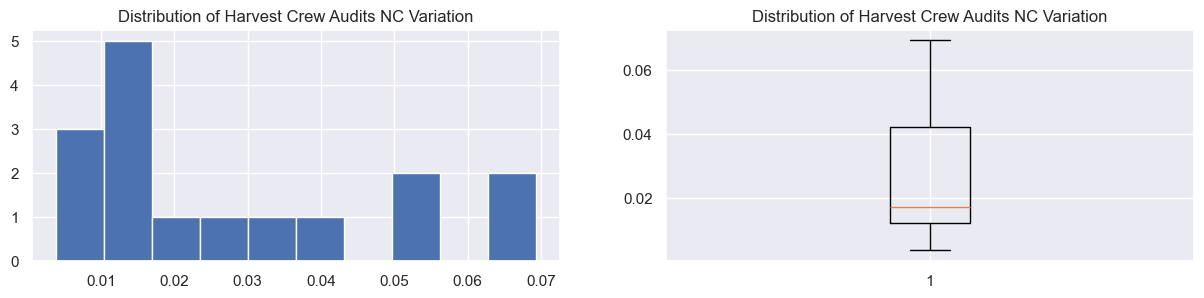

In [1018]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(harvestSTD['StdNC'])
ax1.set_title('Distribution of Harvest Crew Audits NC Variation')
ax2.boxplot(harvestSTD['StdNC'])
ax2.set_title('Distribution of Harvest Crew Audits NC Variation')

plt.show()

### Calculating KPI

In [1019]:
meanSTD_harvest = np.mean(harvestSTD.StdNC)
q1_hcs = np.percentile(harvestSTD.StdNC, 25)
q2_hcs = np.percentile(harvestSTD.StdNC, 50)
q3_hcs = np.percentile(harvestSTD.StdNC, 75)

IQR_hcs = q3_hcs - q1_hcs

UpperThreshold_hcs = q3_hcs + HighVariationNC_restriction * IQR_hcs
LowerThreshold_hcs = q1_hcs - LowVariationNC_restriction * IQR_hcs
if LowerThreshold_hcs < 0:
    LowerThreshold_hcs = harvestSTD['StdNC'].min()
else:
    LowerThreshold_hcs = LowerThreshold_hcs

In [1020]:
hcs_analyzed = harvestSTD
hcs_analyzed['UpperThreshold'] = UpperThreshold_hcs
hcs_analyzed['HighProportionNC'] = ''
hcs_analyzed.loc[hcs_analyzed['StdNC'] > hcs_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
hcs_analyzed.loc[hcs_analyzed['StdNC'] <= hcs_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [1021]:
hcs_analyzed['LowProportionNC'] = ''
hcs_analyzed['LowerThreshold'] = LowerThreshold_hcs
hcs_analyzed.loc[hcs_analyzed['StdNC'] < hcs_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
hcs_analyzed.loc[hcs_analyzed['StdNC'] >= hcs_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [1022]:
low_hcs = hcs_analyzed['LowProportionNC']
high_hcs = hcs_analyzed['HighProportionNC']
hcs_analyzed = pd.merge(low_hcs, high_hcs, on='Auditor', suffixes=('_1', '_2'))
#hcs_analyzed.head()

### Visualization of KPI

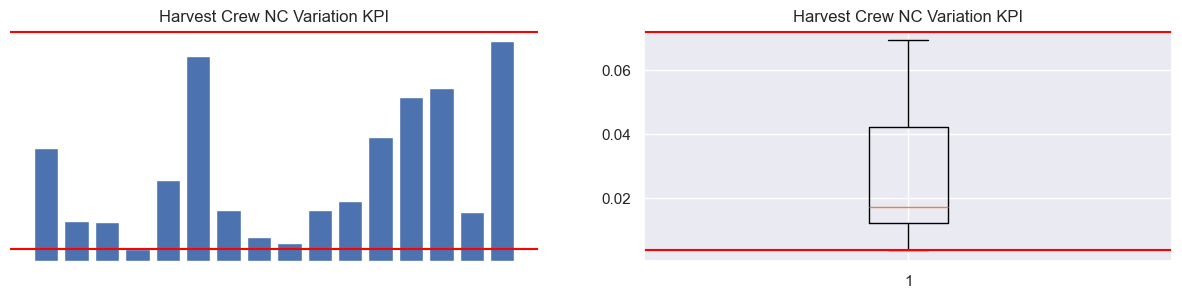

In [1023]:
hcs2 = harvestSTD
hcs2['Auditor'] = harvestSTD.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(hcs2.Auditor,hcs2.StdNC)
ax1.set_title('Harvest Crew NC Variation KPI')
ax1.axhline(y=UpperThreshold_hcs, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_hcs, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(hcs2['StdNC'])
ax2.set_title('Harvest Crew NC Variation KPI')
ax2.axhline(y=UpperThreshold_hcs, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_hcs, xmin=0, color = 'red')

plt.show()  

In [1024]:
#harvestSTD[['StdNC','UpperThreshold','HighVariationNC','LowerThreshold','LowVariationNC']]
harvestSTD = harvestSTD.rename(columns={'HighProportionNC':'HighVariationNC','LowProportionNC':'LowVariationNC'})
mark_hcs = harvestSTD[(harvestSTD.HighVariationNC == 1) | (harvestSTD.LowVariationNC) == 1] == True
#mark_hcs[['HighVariationNC','LowVariationNC']]

## Packinghouse

In [1025]:
packinghouseSTD = df[df['AuditTemplate'].str.contains("Audit type 5", case=False)]
packinghouseSTD = packinghouseSTD[['Auditor','PercentageNC']]
packinghouseSTD = packinghouseSTD.groupby('Auditor').std()
packinghouseSTD = packinghouseSTD.rename(columns={'PercentageNC':'StdNC'})
packinghouseSTD = packinghouseSTD.dropna()
#packinghouseSTD.head()

### Distribution of NC Variation in Packinghouse Audits

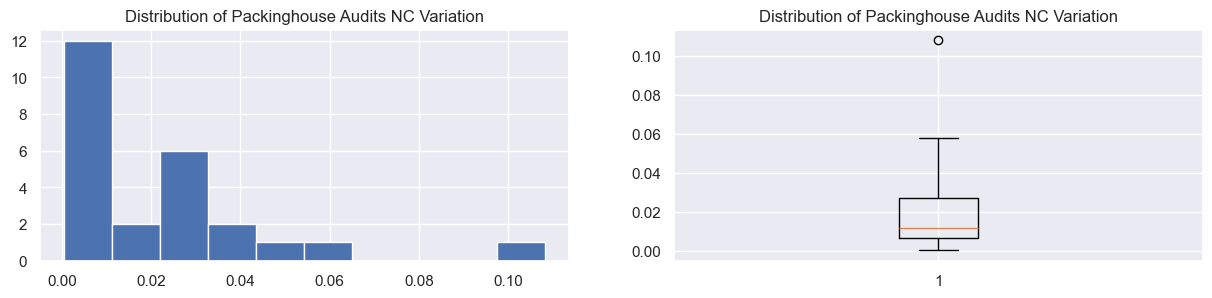

In [1026]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(packinghouseSTD['StdNC'])
ax1.set_title('Distribution of Packinghouse Audits NC Variation')
ax2.boxplot(packinghouseSTD['StdNC'])
ax2.set_title('Distribution of Packinghouse Audits NC Variation')

plt.show()

### Calculating KPI

In [1027]:
meanSTD_packinghouse = np.mean(packinghouseSTD.StdNC)
q1_pkhs = np.percentile(packinghouseSTD.StdNC, 25)
q2_pkhs = np.percentile(packinghouseSTD.StdNC, 50)
q3_pkhs = np.percentile(packinghouseSTD.StdNC, 75)

IQR_pkhs = q3_pkhs - q1_pkhs

UpperThreshold_pkhs = q3_pkhs + HighVariationNC_restriction * IQR_pkhs
LowerThreshold_pkhs = q1_pkhs - LowVariationNC_restriction * IQR_pkhs
if LowerThreshold_pkhs < 0:
    LowerThreshold_pkhs = packinghouseSTD['StdNC'].min()
else:
    LowerThreshold_pkhs = LowerThreshold_pkhs

In [1028]:
pkhs_analyzed = packinghouseSTD
pkhs_analyzed['UpperThreshold'] = UpperThreshold_pkhs
pkhs_analyzed['HighProportionNC'] = ''
pkhs_analyzed.loc[pkhs_analyzed['StdNC'] > pkhs_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
pkhs_analyzed.loc[pkhs_analyzed['StdNC'] <= pkhs_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [1029]:
pkhs_analyzed['LowProportionNC'] = ''
pkhs_analyzed['LowerThreshold'] = LowerThreshold_pkhs
pkhs_analyzed.loc[pkhs_analyzed['StdNC'] < pkhs_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
pkhs_analyzed.loc[pkhs_analyzed['StdNC'] >= pkhs_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [1030]:
low_pkhs = pkhs_analyzed['LowProportionNC']
high_pkhs = pkhs_analyzed['HighProportionNC']
pkhs_analyzed = pd.merge(low_pkhs, high_pkhs, on='Auditor', suffixes=('_1', '_2'))
#pkhs_analyzed.head()

### Visualization of KPI

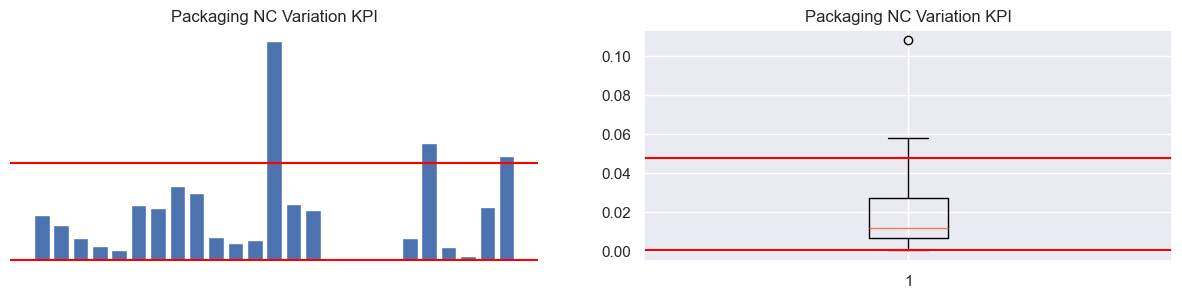

In [1031]:
pkhs2 = packinghouseSTD
pkhs2['Auditor'] = packinghouseSTD.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(pkhs2.Auditor,pkhs2.StdNC)
ax1.set_title('Packaging NC Variation KPI')
ax1.axhline(y=UpperThreshold_pkhs, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_pkhs, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(pkhs2['StdNC'])
ax2.set_title('Packaging NC Variation KPI')
ax2.axhline(y=UpperThreshold_pkhs, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_pkhs, xmin=0, color = 'red')

plt.show()  

In [1032]:
#packinghouseSTD[['StdNC','UpperThreshold','HighVariationNC','LowerThreshold','LowVariationNC']]
packinghouseSTD = packinghouseSTD.rename(columns={'HighProportionNC':'HighVariationNC','LowProportionNC':'LowVariationNC'})
mark_pkhs = packinghouseSTD[(packinghouseSTD.HighVariationNC == 1) | (packinghouseSTD.LowVariationNC) == 1] == True
#mark_pkhs[['HighVariationNC','LowVariationNC']]

### Packaging

In [1033]:
packagingSTD = df[df['AuditTemplate'].str.contains("Audit Type 5", case=False)]
packagingSTD = packagingSTD[['Auditor','PercentageNC']]
packagingSTD = packagingSTD.groupby('Auditor').std()
packagingSTD = packagingSTD.rename(columns={'PercentageNC':'StdNC'})
packagingSTD = packagingSTD.dropna()
#packagingSTD.head()

### Distribution of Variation NC in Packaging Audits

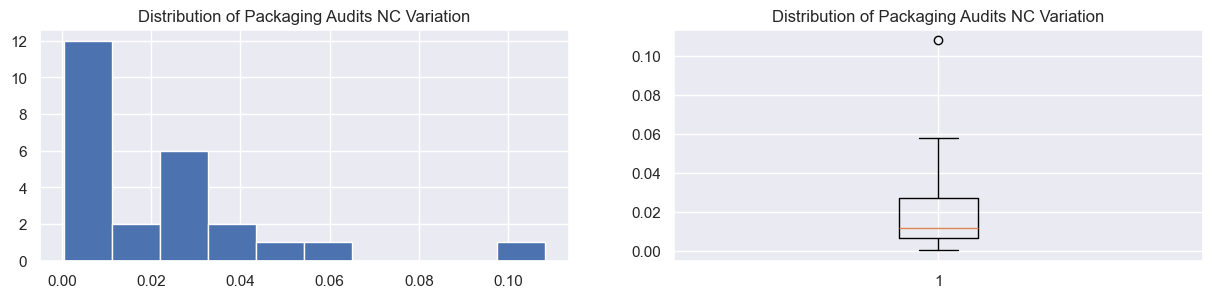

In [1034]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(packagingSTD['StdNC'])
ax1.set_title('Distribution of Packaging Audits NC Variation')
ax2.boxplot(packagingSTD['StdNC'])
ax2.set_title('Distribution of Packaging Audits NC Variation')

plt.show()

### Calculating KPI

In [1035]:
meanSTD_packaging = np.mean(packagingSTD.StdNC)
q1_pks = np.percentile(packagingSTD.StdNC, 25)
q2_pks = np.percentile(packagingSTD.StdNC, 50)
q3_pks = np.percentile(packagingSTD.StdNC, 75)

IQR_pks = q3_pks - q1_pks

UpperThreshold_pks = q3_pks + HighVariationNC_restriction * IQR_pks
LowerThreshold_pks = q1_pks - LowVariationNC_restriction * IQR_pks
if LowerThreshold_pks < 0:
    LowerThreshold_pks = packagingSTD['StdNC'].min()
else:
    LowerThreshold_pks = LowerThreshold_pks

In [1036]:
pks_analyzed = packagingSTD
pks_analyzed['UpperThreshold'] = UpperThreshold_pks
pks_analyzed['HighProportionNC'] = ''
pks_analyzed.loc[pks_analyzed['StdNC'] > pks_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
pks_analyzed.loc[pks_analyzed['StdNC'] <= pks_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [1037]:
pks_analyzed['LowProportionNC'] = ''
pks_analyzed['LowerThreshold'] = LowerThreshold_pks
pks_analyzed.loc[pks_analyzed['StdNC'] < pks_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
pks_analyzed.loc[pks_analyzed['StdNC'] >= pks_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [1038]:
low_pks = pks_analyzed['LowProportionNC']
high_pks = pks_analyzed['HighProportionNC']
pks_analyzed = pd.merge(low_pks, high_pks, on='Auditor', suffixes=('_1', '_2'))
#pks_analyzed.head()

### Visualization of KPI

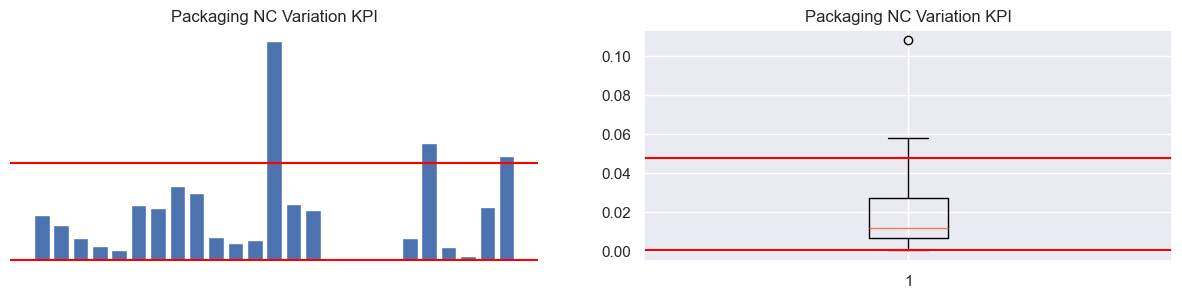

In [1039]:
pks2 = packagingSTD
pks2['Auditor'] = packagingSTD.index

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(pks2.Auditor,pks2.StdNC)
ax1.set_title('Packaging NC Variation KPI')
ax1.axhline(y=UpperThreshold_pks, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_pks, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(pks2['StdNC'])
ax2.set_title('Packaging NC Variation KPI')
ax2.axhline(y=UpperThreshold_pks, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_pks, xmin=0, color = 'red')

plt.show()  

In [1040]:
#packagingSTD[['StdNC','UpperThreshold','HighVariationNC','LowerThreshold','LowVariationNC']]
packagingSTD = packagingSTD.rename(columns={'HighProportionNC':'HighVariationNC','LowProportionNC':'LowVariationNC'})
mark_pks = packagingSTD[(packagingSTD.HighVariationNC == 1) | (packagingSTD.LowVariationNC) == 1] == True
#mark_pks[['HighVariationNC','LowVariationNC']]

## Storage & Distribution Center

In [1041]:
storageSTD = df[df['AuditTemplate'].str.contains("Audit type 6", case=False)]
storageSTD = storageSTD[['Auditor','PercentageNC']]
storageSTD = storageSTD.groupby('Auditor').std()
storageSTD = storageSTD.rename(columns={'PercentageNC':'StdNC'})
storageSTD = storageSTD.dropna()
#storageSTD.head()

### Distribution of Variation NC in Storage & Distribution Center

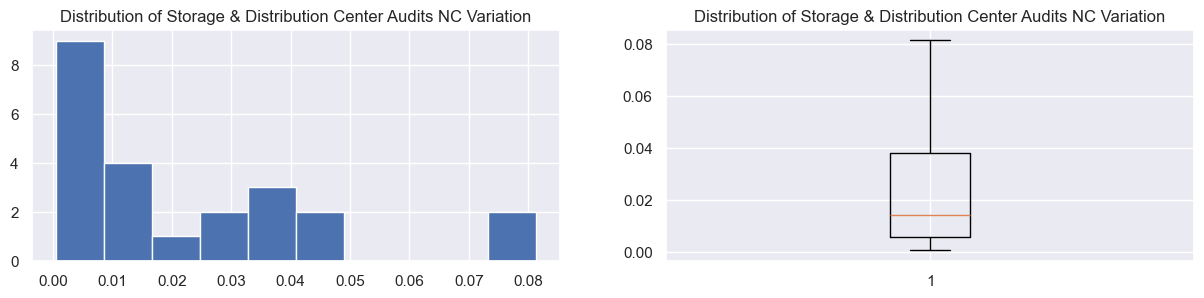

In [1042]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(storageSTD['StdNC'])
ax1.set_title('Distribution of Storage & Distribution Center Audits NC Variation')
ax2.boxplot(storageSTD['StdNC'])
ax2.set_title('Distribution of Storage & Distribution Center Audits NC Variation')

plt.show()

### Calculating of KPI

In [1043]:
if storageSTD.empty:
    print('DataFrame is empty!')
else:
    meanSTD_storage = np.mean(storageSTD.StdNC)
    q1_sts = np.percentile(storageSTD.StdNC, 25)
    q2_sts = np.percentile(storageSTD.StdNC, 50)
    q3_sts = np.percentile(storageSTD.StdNC, 75)

    IQR_sts = q3_sts - q1_sts

    UpperThreshold_sts = q3_sts + HighVariationNC_restriction * IQR_sts
    LowerThreshold_sts = q1_sts - LowVariationNC_restriction * IQR_sts
    if LowerThreshold_sts < storageSTD['StdNC'].min():
        LowerThreshold_sts = storageSTD['StdNC'].min()
    else:
        LowerThreshold_sts = LowerThreshold_sts

In [1044]:
if storageSTD.empty:
    print('DataFrame is empty!')
else:
    sts_analyzed = storageSTD
    sts_analyzed['UpperThreshold'] = UpperThreshold_sts
    sts_analyzed['HighProportionNC'] = ''
    sts_analyzed.loc[sts_analyzed['StdNC'] > sts_analyzed['UpperThreshold'], 'HighProportionNC'] = 1
    sts_analyzed.loc[sts_analyzed['StdNC'] <= sts_analyzed['UpperThreshold'], 'HighProportionNC'] = 0

In [1045]:
if storageSTD.empty:
    print('DataFrame is empty!')
else:
    sts_analyzed['LowProportionNC'] = ''
    sts_analyzed['LowerThreshold'] = LowerThreshold_sts
    sts_analyzed.loc[sts_analyzed['StdNC'] < sts_analyzed['LowerThreshold'], 'LowProportionNC'] = 1
    sts_analyzed.loc[sts_analyzed['StdNC'] >= sts_analyzed['LowerThreshold'], 'LowProportionNC'] = 0

In [1046]:
if storageSTD.empty:
    print('DataFrame is empty!')
else:
    low_sts = sts_analyzed['LowProportionNC']
    high_sts = sts_analyzed['HighProportionNC']
    sts_analyzed = pd.merge(low_sts, high_sts, on='Auditor', suffixes=('_1', '_2'))
    #sts_analyzed.head()

### Visualization of KPI

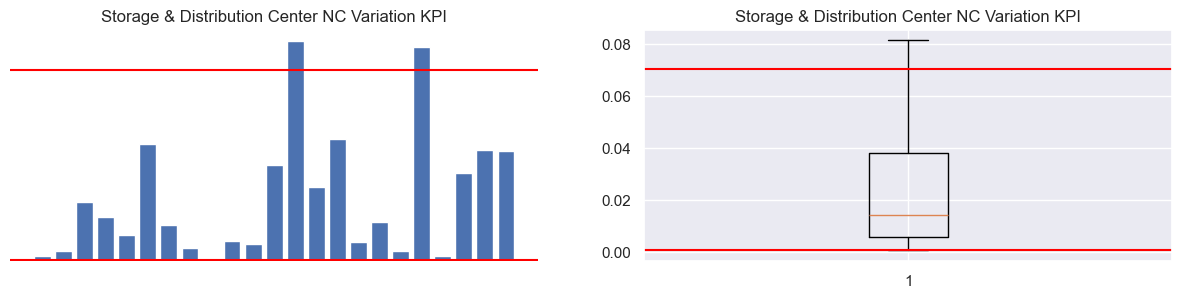

In [1047]:
if storageSTD.empty:
    print('DataFrame is empty!')
else:
    sts2 = storageSTD
    sts2['Auditor'] = storageSTD.index

    f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
    ax1.bar(sts2.Auditor,sts2.StdNC)
    ax1.set_title('Storage & Distribution Center NC Variation KPI')
    ax1.axhline(y=UpperThreshold_sts, xmin=0, color = 'red')
    ax1.axhline(y=LowerThreshold_sts, xmin=0, color = 'red')
    ax1.axis('off')
    ax2.boxplot(sts2['StdNC'])
    ax2.set_title('Storage & Distribution Center NC Variation KPI')
    ax2.axhline(y=UpperThreshold_sts, xmin=0, color = 'red')
    ax2.axhline(y=LowerThreshold_sts, xmin=0, color = 'red')

    plt.show()    

In [1048]:
if storageSTD.empty:
    print('DataFrame is empty!')
else:
    #storageSTD[['StdNC','UpperThreshold','HighVariationNC','LowerThreshold','LowVariationNC']]
    storageSTD = storageSTD.rename(columns={'HighProportionNC':'HighVariationNC','LowProportionNC':'LowVariationNC'})
    mark_sts = storageSTD[(storageSTD.HighVariationNC == 1) | (storageSTD.LowVariationNC) == 1] == True
    #mark_sts[['HighVariationNC','LowVariationNC']]

In [1049]:
if storageSTD.empty:
    print('DataFrame is empty!')
else:
    #storageSTD[['StdNC','UpperThreshold','HighVariationNC','LowerThreshold','LowVariationNC']]
    storageSTD = storageSTD.rename(columns={'HighProportionNC':'HighVariationNC','LowProportionNC':'LowVariationNC'})
    mark_sts = storageSTD[(storageSTD.HighVariationNC == 1) | (storageSTD.LowVariationNC) == 1] == True
    #mark_sts[['HighVariationNC','LowVariationNC']]

# KPI 5 and 6

### Change in NC in consecutive years 

## Ranch

In [1050]:
ranch_2 = df_2[df_2['AuditTemplate'].str.contains("Audit type 5", case=False)]
ranch_2 = ranch_2[['Auditor','PercentageNC']]
ranch_2 = ranch_2.groupby('Auditor').mean()
ranch_1 = ranch[['Auditor','PercentageNC']]
ranch_1 = ranch_1.reset_index(drop=True)
ranch_12 = pd.merge(ranch_1, ranch_2, on='Auditor', suffixes=('_1', '_2'))
ranch_12['ChangeInAyear'] = np.absolute(ranch_12['PercentageNC_1'] - ranch_12['PercentageNC_2'])
#ranch_12.head()

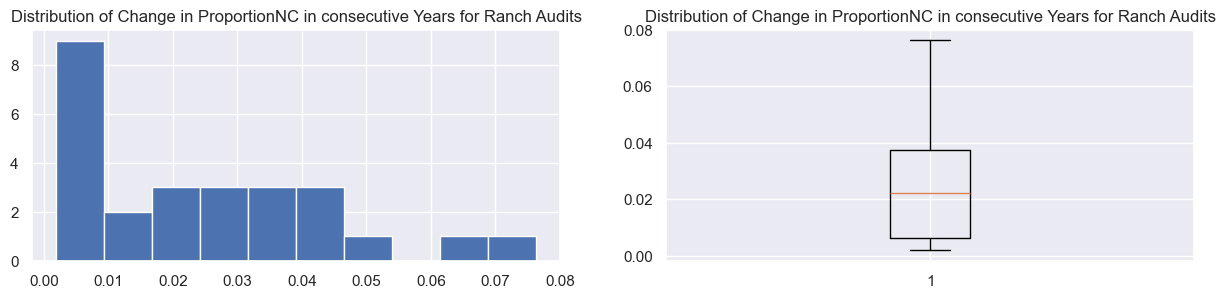

In [1051]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(ranch_12['ChangeInAyear'])
ax1.set_title('Distribution of Change in ProportionNC in consecutive Years for Ranch Audits')
ax2.boxplot(ranch_12['ChangeInAyear'])
ax2.set_title('Distribution of Change in ProportionNC in consecutive Years for Ranch Audits')

plt.show()

### Calculating KPI

In [1052]:
mean_packinghouse = np.mean(ranch_12.ChangeInAyear)
q1_rh12 = np.percentile(ranch_12.ChangeInAyear, 25)
q2_rh12 = np.percentile(ranch_12.ChangeInAyear, 50)
q3_rh12 = np.percentile(ranch_12.ChangeInAyear, 75)

IQR_rh12 = q3_rh12 - q1_rh12

UpperThreshold_rh12 = q3_rh12 + HighChangeinAYearNC_restriction * IQR_rh12
LowerThreshold_rh12 = q1_rh12 - LowChangeinAYearNC_restriction * IQR_rh12
if LowerThreshold_rh12 < 0:
    LowerThreshold_rh12 = ranch_12['ChangeInAyear'].min()
else:
    LowerThreshold_rh12 = LowerThreshold_rh12

In [1053]:
rh12_analyzed = ranch_12
rh12_analyzed['UpperThreshold'] = UpperThreshold_rh12
rh12_analyzed['HighVariationNCinAYear'] = ''
rh12_analyzed.loc[rh12_analyzed['ChangeInAyear'] > rh12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 1
rh12_analyzed.loc[rh12_analyzed['ChangeInAyear'] <= rh12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 0

In [1054]:
rh12_analyzed['LowVariationNCinAYear'] = ''
rh12_analyzed['LowerThreshold'] = LowerThreshold_rh12
rh12_analyzed.loc[rh12_analyzed['ChangeInAyear'] < rh12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 1
rh12_analyzed.loc[rh12_analyzed['ChangeInAyear'] >= rh12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 0

In [1055]:
low_rh12 = rh12_analyzed[['Auditor','LowVariationNCinAYear']]
high_rh12 = rh12_analyzed[['Auditor','HighVariationNCinAYear']]
rh12_analyzed = pd.merge(low_rh12, high_rh12, on='Auditor', suffixes=('_1', '_2'))
#rh12_analyzed.head()

### Visualization of KPI

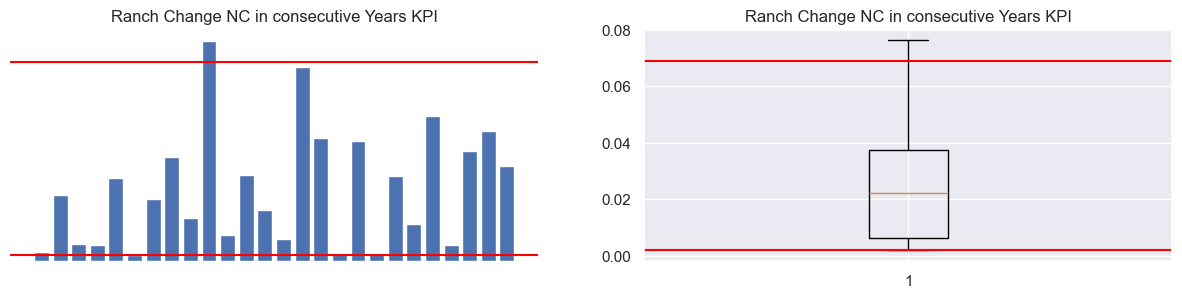

In [1056]:
if ranch_12.empty:
    print('DataFrame is empty!')
else:
    rh12_2 = ranch_12

    f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
    ax1.bar(rh12_2.Auditor,rh12_2.ChangeInAyear)
    ax1.set_title('Ranch Change NC in consecutive Years KPI')
    ax1.axhline(y=UpperThreshold_rh12, xmin=0, color = 'red')
    ax1.axhline(y=LowerThreshold_rh12, xmin=0, color = 'red')
    ax1.axis('off')
    ax2.boxplot(rh12_2['ChangeInAyear'])
    ax2.set_title('Ranch Change NC in consecutive Years KPI')
    ax2.axhline(y=UpperThreshold_rh12, xmin=0, color = 'red')
    ax2.axhline(y=LowerThreshold_rh12, xmin=0, color = 'red')

    plt.show()    

In [1057]:
if 'Auditor' in ranch_12:
    ranch_12.set_index('Auditor',inplace = True)
ranch_12['Auditor'] = ranch_12.index
ranch_12 = ranch_12.rename(columns={'PercentageNC_1':'PercentajeNC_2021','PercentageNC_2':'PercentageNC_2020'})
mark_rh12 = ranch_12[(ranch_12.HighVariationNCinAYear == 1) | (ranch_12.LowVariationNCinAYear) == 1] == True
#mark_rh12[['HighVariationNCinAYear','LowVariationNCinAYear']]

In [1058]:
ranch12 = ranch_12[['Auditor','ChangeInAyear','UpperThreshold','HighVariationNCinAYear','LowerThreshold','LowVariationNCinAYear']]
#ranch_12

## Greenhouse

In [1059]:
greenhouse_2 = df_2[df_2['AuditTemplate'].str.contains("Audit type 2", case=False)]
greenhouse_2 = greenhouse_2[['Auditor','PercentageNC']]
greenhouse_2 = greenhouse_2.groupby('Auditor').mean()
greenhouse_1 = greenhouse[['Auditor','PercentageNC']]
greenhouse_1 = greenhouse_1.reset_index(drop=True)
greenhouse_12 = pd.merge(greenhouse_1, greenhouse_2, on='Auditor', suffixes=('_1', '_2'))
greenhouse_12['ChangeInAyear'] = np.absolute(greenhouse_12['PercentageNC_1'] - greenhouse_12['PercentageNC_2'])
#greenhouse_12.head()

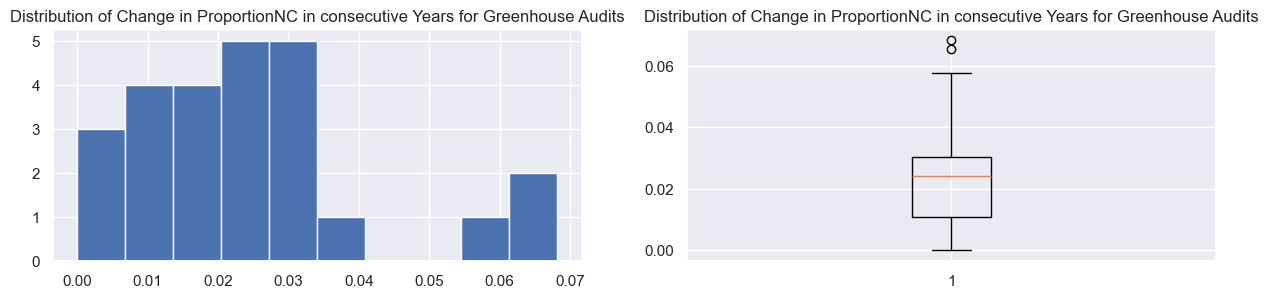

In [1060]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(greenhouse_12['ChangeInAyear'])
ax1.set_title('Distribution of Change in ProportionNC in consecutive Years for Greenhouse Audits')
ax2.boxplot(greenhouse_12['ChangeInAyear'])
ax2.set_title('Distribution of Change in ProportionNC in consecutive Years for Greenhouse Audits')

plt.show()

### Calculating KPI

In [1061]:
if greenhouse_12.empty:
    print('DataFrame is empty!')
else:
    mean_greenhouse = np.mean(greenhouse_12.ChangeInAyear)
    q1_gh12 = np.percentile(greenhouse_12.ChangeInAyear, 25)
    q2_gh12 = np.percentile(greenhouse_12.ChangeInAyear, 50)
    q3_gh12 = np.percentile(greenhouse_12.ChangeInAyear, 75)

    IQR_gh12 = q3_gh12 - q1_gh12

    UpperThreshold_gh12 = q3_gh12 + HighChangeinAYearNC_restriction * IQR_gh12
    LowerThreshold_gh12 = q1_gh12 - LowChangeinAYearNC_restriction * IQR_gh12
    if LowerThreshold_gh12 < 0:
        LowerThreshold_gh12 = greenhouse_12['ChangeInAyear'].min()
    else:
        LowerThreshold_gh12 = LowerThreshold_gh12

In [1062]:
if greenhouse_12.empty:
    print('DataFrame is empty!')
else:
    gh12_analyzed = greenhouse_12
    gh12_analyzed['UpperThreshold'] = UpperThreshold_gh12
    gh12_analyzed['HighVariationNCinAYear'] = ''
    gh12_analyzed.loc[gh12_analyzed['ChangeInAyear'] > gh12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 1
    gh12_analyzed.loc[gh12_analyzed['ChangeInAyear'] <= gh12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 0

In [1063]:
if greenhouse_12.empty:
    print('DataFrame is empty!')
else:
    gh12_analyzed['LowVariationNCinAYear'] = ''
    gh12_analyzed['LowerThreshold'] = LowerThreshold_gh12
    gh12_analyzed.loc[gh12_analyzed['ChangeInAyear'] < gh12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 1
    gh12_analyzed.loc[gh12_analyzed['ChangeInAyear'] >= gh12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 0

In [1064]:
if greenhouse_12.empty:
    print('DataFrame is empty!')
else:
    low_gh12 = gh12_analyzed[['Auditor','LowVariationNCinAYear']]
    high_gh12 = gh12_analyzed[['Auditor','HighVariationNCinAYear']]
    gh12_analyzed = pd.merge(low_gh12, high_gh12, on='Auditor', suffixes=('_1', '_2'))
    #gh12_analyzed.head()

### Visualization of KPI

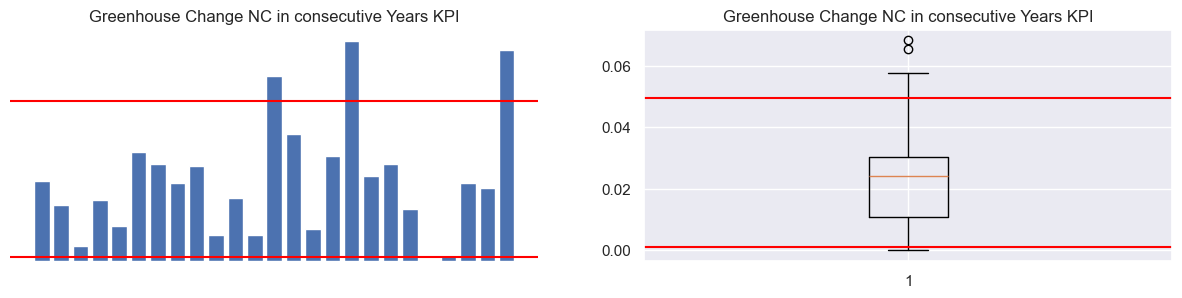

In [1065]:
if greenhouse_12.empty:
    print('DataFrame is empty!')
else:
    gh12_2 = greenhouse_12

    f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
    ax1.bar(gh12_2.Auditor,gh12_2.ChangeInAyear)
    ax1.set_title('Greenhouse Change NC in consecutive Years KPI')
    ax1.axhline(y=UpperThreshold_gh12, xmin=0, color = 'red')
    ax1.axhline(y=LowerThreshold_gh12, xmin=0, color = 'red')
    ax1.axis('off')
    ax2.boxplot(gh12_2['ChangeInAyear'])
    ax2.set_title('Greenhouse Change NC in consecutive Years KPI')
    ax2.axhline(y=UpperThreshold_gh12, xmin=0, color = 'red')
    ax2.axhline(y=LowerThreshold_gh12, xmin=0, color = 'red')

    plt.show()    

In [1066]:
if greenhouse_12.empty:
    print('DataFrame is empty!')
else:
    if 'Auditor' in greenhouse_12:
        greenhouse_12.set_index('Auditor',inplace = True)
    greenhouse_12['Auditor'] = greenhouse_12.index
    greenhouse_12 = greenhouse_12.rename(columns={'PercentageNC_1':'PercentajeNC_2021','PercentageNC_2':'PercentageNC_2020'})
    mark_gh12 = greenhouse_12[(greenhouse_12.HighVariationNCinAYear == 1) | (greenhouse_12.LowVariationNCinAYear) == 1] == True
    #mark_gh12[['HighVariationNCinAYear','LowVariationNCinAYear']]

In [1067]:
if greenhouse_12.empty:
    print('DataFrame is empty!')
else:
    greenhouse_12 = greenhouse_12[['Auditor','ChangeInAyear','UpperThreshold','HighVariationNCinAYear','LowerThreshold','LowVariationNCinAYear']]
    #greenhouse_12

## Cooling and Cold Storage

In [1068]:
cold_2 = df_2[df_2['AuditTemplate'].str.contains("Audit type 3", case=False)]
cold_2 = cold_2[['Auditor','PercentageNC']]
cold_2 = cold_2.groupby('Auditor').mean()
cold_1 = cold[['Auditor','PercentageNC']]
cold_1 = cold_1.reset_index(drop=True)
cold_12 = pd.merge(cold_1, cold_2, on='Auditor', suffixes=('_1', '_2'))
cold_12['ChangeInAyear'] = np.absolute(cold_12['PercentageNC_1'] - cold_12['PercentageNC_2'])
#cold_12.head()

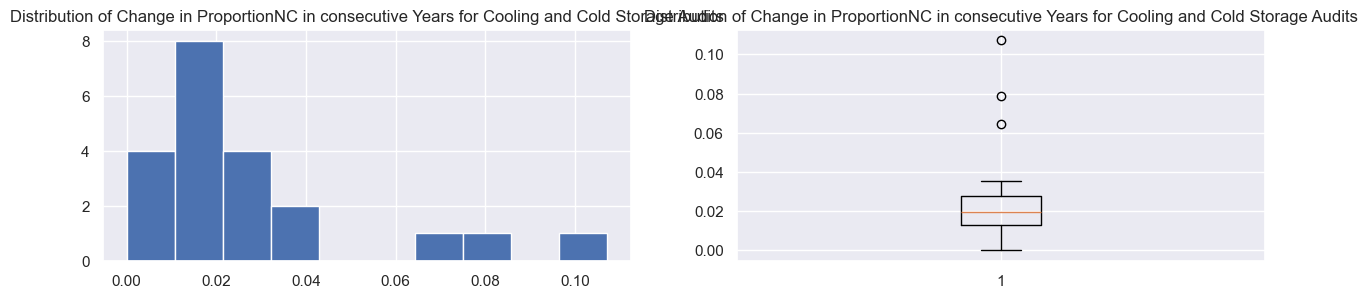

In [1069]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(cold_12['ChangeInAyear'])
ax1.set_title('Distribution of Change in ProportionNC in consecutive Years for Cooling and Cold Storage Audits')
ax2.boxplot(cold_12['ChangeInAyear'])
ax2.set_title('Distribution of Change in ProportionNC in consecutive Years for Cooling and Cold Storage Audits')

plt.show()

### Calculating KPI

In [1070]:
if cold_12.empty:
    print('DataFrame is empty!')
else:
    mean_coldStorage = np.mean(cold_12.ChangeInAyear)
    q1_cs12 = np.percentile(cold_12.ChangeInAyear, 25)
    q2_cs12 = np.percentile(cold_12.ChangeInAyear, 50)
    q3_cs12 = np.percentile(cold_12.ChangeInAyear, 75)

    IQR_cs12 = q3_cs12 - q1_cs12

    UpperThreshold_cs12 = q3_cs12 + HighChangeinAYearNC_restriction * IQR_cs12
    LowerThreshold_cs12 = q1_cs12 - LowChangeinAYearNC_restriction * IQR_cs12
    if LowerThreshold_cs12 < 0:
        LowerThreshold_cs12 = cold_12['ChangeInAyear'].min()
    else:
        LowerThreshold_cs12 = LowerThreshold_cs12

In [1071]:
if cold_12.empty:
    print('DataFrame is empty!')
else:
    cs12_analyzed = cold_12
    cs12_analyzed['UpperThreshold'] = UpperThreshold_cs12
    cs12_analyzed['HighVariationNCinAYear'] = ''
    cs12_analyzed.loc[cs12_analyzed['ChangeInAyear'] > cs12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 1
    cs12_analyzed.loc[cs12_analyzed['ChangeInAyear'] <= cs12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 0

In [1072]:
if cold_12.empty:
    print('DataFrame is empty!')
else:
    cs12_analyzed['LowVariationNCinAYear'] = ''
    cs12_analyzed['LowerThreshold'] = LowerThreshold_cs12
    cs12_analyzed.loc[cs12_analyzed['ChangeInAyear'] < cs12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 1
    cs12_analyzed.loc[cs12_analyzed['ChangeInAyear'] >= cs12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 0

In [1073]:
if cold_12.empty:
    print('DataFrame is empty!')
else:
    low_cs12 = cs12_analyzed[['Auditor','LowVariationNCinAYear']]
    high_cs12 = cs12_analyzed[['Auditor','HighVariationNCinAYear']]
    cs12_analyzed = pd.merge(low_cs12, high_cs12, on='Auditor', suffixes=('_1', '_2'))
    #cs12_analyzed.head()

### Visualization of KPI

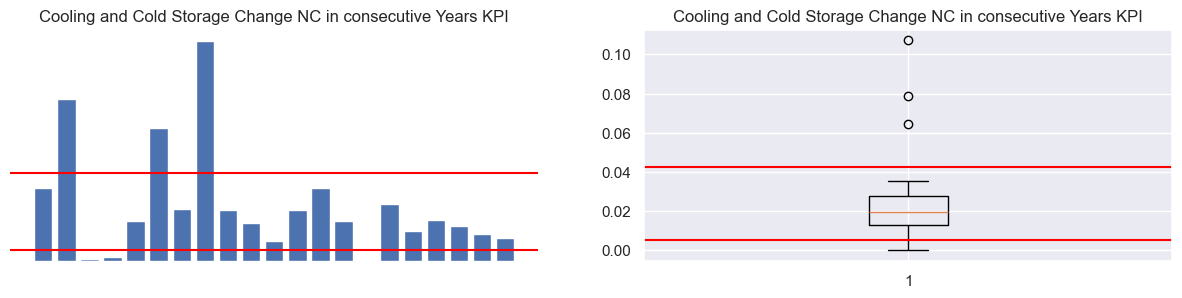

In [1074]:
if cold_12.empty:
    print('DataFrame is empty!')
else:
    cs12_2 = cold_12

    f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
    ax1.bar(cs12_2.Auditor,cs12_2.ChangeInAyear)
    ax1.set_title('Cooling and Cold Storage Change NC in consecutive Years KPI')
    ax1.axhline(y=UpperThreshold_cs12, xmin=0, color = 'red')
    ax1.axhline(y=LowerThreshold_cs12, xmin=0, color = 'red')
    ax1.axis('off')
    ax2.boxplot(cold_12['ChangeInAyear'])
    ax2.set_title('Cooling and Cold Storage Change NC in consecutive Years KPI')
    ax2.axhline(y=UpperThreshold_cs12, xmin=0, color = 'red')
    ax2.axhline(y=LowerThreshold_cs12, xmin=0, color = 'red')

    plt.show()    

In [1075]:
if cold_12.empty:
    print('DataFrame is empty!')
else:
    if 'Auditor' in cold_12:
        cold_12.set_index('Auditor',inplace = True)
    cold_12['Auditor'] = cold_12.index
    cold_12 = cold_12.rename(columns={'PercentageNC_1':'PercentajeNC_2021','PercentageNC_2':'PercentageNC_2020'})
    mark_cs12 = cold_12[(cold_12.HighVariationNCinAYear == 1) | (cold_12.LowVariationNCinAYear) == 1] == True
    #mark_cs12[['HighVariationNCinAYear','LowVariationNCinAYear']]

In [1076]:
if cold_12.empty:
    print('DataFrame is empty!')
else:
    cold_12 = cold_12[['Auditor','ChangeInAyear','UpperThreshold','HighVariationNCinAYear','LowerThreshold','LowVariationNCinAYear']]
    #cold_12

## Harvest Crew

In [1077]:
harv_2 = df_2[df_2['AuditTemplate'].str.contains("Audit type 4", case=False)]
harv_2 = harv_2[['Auditor','PercentageNC']]
harv_2 = harv_2.groupby('Auditor').mean()
harv_1 = harvc[['Auditor','PercentageNC']]
harv_1 = harv_1.reset_index(drop=True)
harv_12 = pd.merge(harv_1, harv_2, on='Auditor', suffixes=('_1', '_2'))
harv_12['ChangeInAyear'] = np.absolute(harv_12['PercentageNC_1'] - harv_12['PercentageNC_2'])
#harv_12.head()

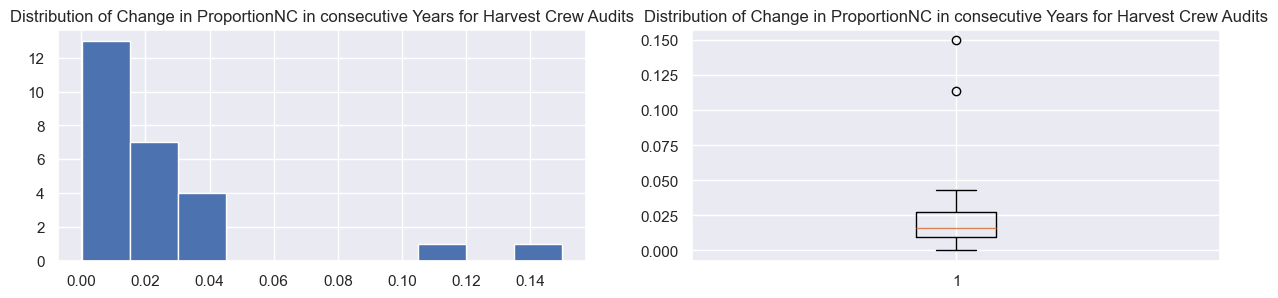

In [1078]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(harv_12['ChangeInAyear'])
ax1.set_title('Distribution of Change in ProportionNC in consecutive Years for Harvest Crew Audits')
ax2.boxplot(harv_12['ChangeInAyear'])
ax2.set_title('Distribution of Change in ProportionNC in consecutive Years for Harvest Crew Audits')

plt.show()

In [1079]:
mean_harv = np.mean(harv_12.ChangeInAyear)
q1_hc12 = np.percentile(harv_12.ChangeInAyear, 25)
q2_hc12 = np.percentile(harv_12.ChangeInAyear, 50)
q3_hc12 = np.percentile(harv_12.ChangeInAyear, 75)

IQR_hc12 = q3_hc12 - q1_hc12

UpperThreshold_hc12 = q3_hc12 + HighChangeinAYearNC_restriction * IQR_hc12
LowerThreshold_hc12 = q1_hc12 - LowChangeinAYearNC_restriction * IQR_hc12
if LowerThreshold_hc12 < 0:
    LowerThreshold_hc12 = harv_12['ChangeInAyear'].min()
else:
    LowerThreshold_hc12 = LowerThreshold_hc12

In [1080]:
hc12_analyzed = harv_12
hc12_analyzed['UpperThreshold'] = UpperThreshold_hc12
hc12_analyzed['HighVariationNCinAYear'] = ''
hc12_analyzed.loc[hc12_analyzed['ChangeInAyear'] > hc12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 1
hc12_analyzed.loc[hc12_analyzed['ChangeInAyear'] <= hc12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 0

In [1081]:
hc12_analyzed['LowVariationNCinAYear'] = ''
hc12_analyzed['LowerThreshold'] = LowerThreshold_hc12
hc12_analyzed.loc[hc12_analyzed['ChangeInAyear'] < hc12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 1
hc12_analyzed.loc[hc12_analyzed['ChangeInAyear'] >= hc12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 0

In [1082]:
low_hc12 = hc12_analyzed[['Auditor','LowVariationNCinAYear']]
high_hc12 = hc12_analyzed[['Auditor','HighVariationNCinAYear']]
hc12_analyzed = pd.merge(low_hc12, high_hc12, on='Auditor', suffixes=('_1', '_2'))
#hc12_analyzed.head()

### Visualization of KPI

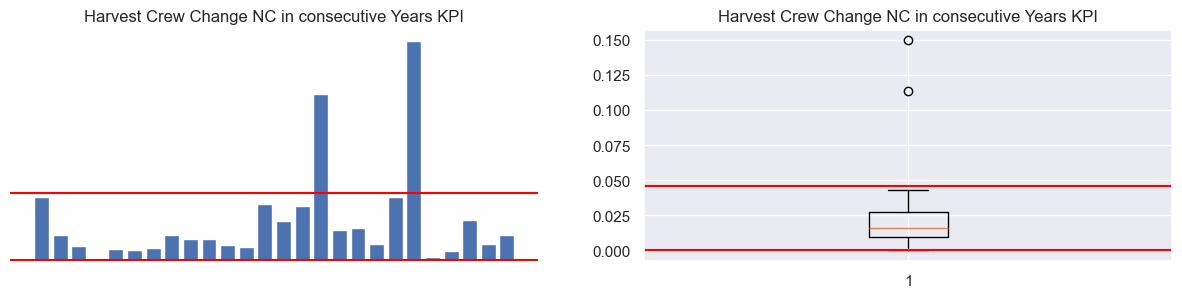

In [1083]:
hc12_2 = harv_12

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(hc12_2.Auditor,hc12_2.ChangeInAyear)
ax1.set_title('Harvest Crew Change NC in consecutive Years KPI')
ax1.axhline(y=UpperThreshold_hc12, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_hc12, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(harv_12['ChangeInAyear'])
ax2.set_title('Harvest Crew Change NC in consecutive Years KPI')
ax2.axhline(y=UpperThreshold_hc12, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_hc12, xmin=0, color = 'red')

plt.show()

In [1084]:
if 'Auditor' in harv_12:
    harv_12.set_index('Auditor',inplace = True)
harv_12['Auditor'] = harv_12.index
harv_12 = harv_12.rename(columns={'PercentageNC_1':'PercentajeNC_2021','PercentageNC_2':'PercentageNC_2020'})
mark_hc12 = harv_12[(harv_12.HighVariationNCinAYear == 1) | (harv_12.LowVariationNCinAYear) == 1] == True
#mark_hc12[['HighVariationNCinAYear','LowVariationNCinAYear']]

In [1085]:
harv_12 = harv_12[['Auditor','ChangeInAyear','UpperThreshold','HighVariationNCinAYear','LowerThreshold','LowVariationNCinAYear']]
#harv_12

## Packinghouse

In [1086]:
packinghouse_2 = df_2[df_2['AuditTemplate'].str.contains("Audit type 5", case=False)]
packinghouse_2 = packinghouse_2[['Auditor','PercentageNC']]
packinghouse_2 = packinghouse_2.groupby('Auditor').mean()
packinghouse_1 = packinghouse[['Auditor','PercentageNC']]
packinghouse_1 = packinghouse_1.reset_index(drop=True)
packinghouse_12 = pd.merge(packinghouse_1, packinghouse_2, on='Auditor', suffixes=('_1', '_2'))
packinghouse_12['ChangeInAyear'] = np.absolute(packinghouse_12['PercentageNC_1'] - packinghouse_12['PercentageNC_2'])
#packinghouse_12.head()

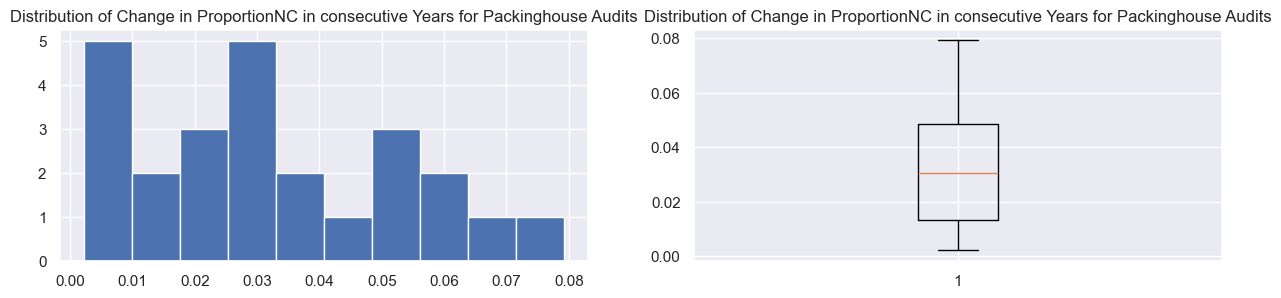

In [1087]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(packinghouse_12['ChangeInAyear'])
ax1.set_title('Distribution of Change in ProportionNC in consecutive Years for Packinghouse Audits')
ax2.boxplot(packinghouse_12['ChangeInAyear'])
ax2.set_title('Distribution of Change in ProportionNC in consecutive Years for Packinghouse Audits')

plt.show()

### Calculating KPI

In [1088]:
mean_harv = np.mean(packinghouse_12.ChangeInAyear)
q1_pkh12 = np.percentile(packinghouse_12.ChangeInAyear, 25)
q2_pkh12 = np.percentile(packinghouse_12.ChangeInAyear, 50)
q3_pkh12 = np.percentile(packinghouse_12.ChangeInAyear, 75)

IQR_pkh12 = q3_pkh12 - q1_pkh12

UpperThreshold_pkh12 = q3_pkh12 + HighChangeinAYearNC_restriction * IQR_pkh12
LowerThreshold_pkh12 = q1_pkh12 - LowChangeinAYearNC_restriction * IQR_pkh12
if LowerThreshold_pkh12 < 0:
    LowerThreshold_pkh12 = packinghouse_12['ChangeInAyear'].min()
else:
    LowerThreshold_pkh12 = LowerThreshold_pkh12

In [1089]:
pkh12_analyzed = packinghouse_12
pkh12_analyzed['UpperThreshold'] = UpperThreshold_pkh12
pkh12_analyzed['HighVariationNCinAYear'] = ''
pkh12_analyzed.loc[pkh12_analyzed['ChangeInAyear'] > pkh12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 1
pkh12_analyzed.loc[pkh12_analyzed['ChangeInAyear'] <= pkh12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 0

In [1090]:
pkh12_analyzed['LowVariationNCinAYear'] = ''
pkh12_analyzed['LowerThreshold'] = LowerThreshold_pkh12
pkh12_analyzed.loc[pkh12_analyzed['ChangeInAyear'] < pkh12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 1
pkh12_analyzed.loc[pkh12_analyzed['ChangeInAyear'] >= pkh12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 0

In [1091]:
low_pkh12 = pkh12_analyzed[['Auditor','LowVariationNCinAYear']]
high_pkh12 = pkh12_analyzed[['Auditor','HighVariationNCinAYear']]
pkh12_analyzed = pd.merge(low_pkh12, high_pkh12, on='Auditor', suffixes=('_1', '_2'))
#pkh12_analyzed.head()

### Visualization of KPI

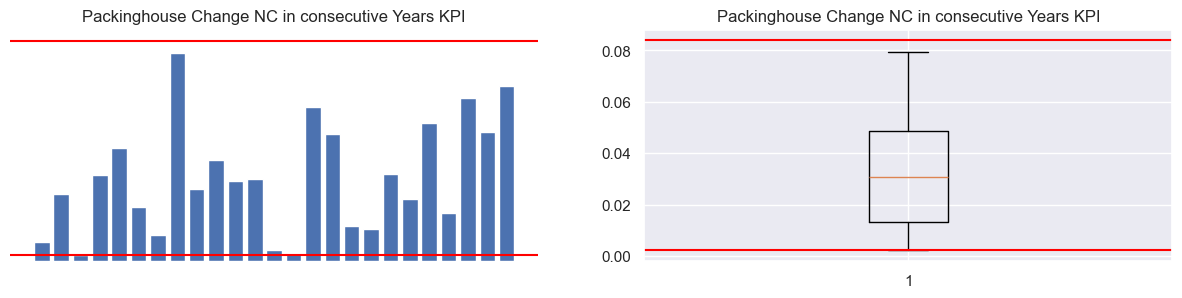

In [1092]:
pkh12_2 = packinghouse_12

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(pkh12_2.Auditor,pkh12_2.ChangeInAyear)
ax1.set_title('Packinghouse Change NC in consecutive Years KPI')
ax1.axhline(y=UpperThreshold_pkh12, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_pkh12, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(packinghouse_12['ChangeInAyear'])
ax2.set_title('Packinghouse Change NC in consecutive Years KPI')
ax2.axhline(y=UpperThreshold_pkh12, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_pkh12, xmin=0, color = 'red')

plt.show()

In [1093]:
if 'Auditor' in packinghouse_12:
    packinghouse_12.set_index('Auditor',inplace = True)
packinghouse_12['Auditor'] = packinghouse_12.index
packinghouse_12 = packinghouse_12.rename(columns={'PercentageNC_1':'PercentajeNC_2021','PercentageNC_2':'PercentageNC_2020'})
mark_pkh12 = packinghouse_12[(packinghouse_12.HighVariationNCinAYear == 1) | (packinghouse_12.LowVariationNCinAYear) == 1] == True
#mark_pkh12[['HighVariationNCinAYear','LowVariationNCinAYear']]

In [1094]:
packinghouse_12 = packinghouse_12[['Auditor','ChangeInAyear','UpperThreshold','HighVariationNCinAYear','LowerThreshold','LowVariationNCinAYear']]
#packinghouse_12

## Packaging

In [1095]:
packaging_2 = df_2[df_2['AuditTemplate'].str.contains("Audit type 6", case=False)]
packaging_2 = packaging_2[['Auditor','PercentageNC']]
packaging_2 = packaging_2.groupby('Auditor').mean()
packaging_1 = packaging[['Auditor','PercentageNC']]
packaging_1 = packaging_1.reset_index(drop=True)
packaging_12 = pd.merge(packaging_1, packaging_2, on='Auditor', suffixes=('_1', '_2'))
packaging_12['ChangeInAyear'] = np.absolute(packaging_12['PercentageNC_1'] - packaging_12['PercentageNC_2'])
#packaging_12.head()

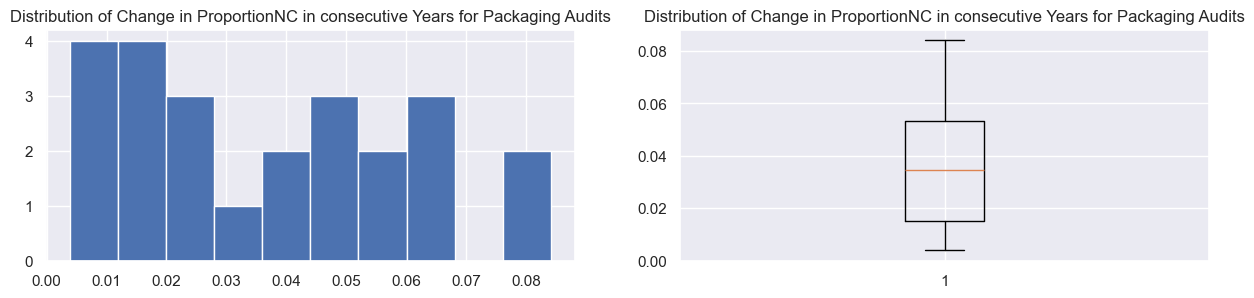

In [1096]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(packaging_12['ChangeInAyear'])
ax1.set_title('Distribution of Change in ProportionNC in consecutive Years for Packaging Audits')
ax2.boxplot(packaging_12['ChangeInAyear'])
ax2.set_title('Distribution of Change in ProportionNC in consecutive Years for Packaging Audits')

plt.show()

### Calculating KPI

In [1097]:
mean_packaging = np.mean(packaging_12.ChangeInAyear)
q1_pk12 = np.percentile(packaging_12.ChangeInAyear, 25)
q2_pk12 = np.percentile(packaging_12.ChangeInAyear, 50)
q3_pk12 = np.percentile(packaging_12.ChangeInAyear, 75)

IQR_pk12 = q3_pk12 - q1_pk12

UpperThreshold_pk12 = q3_pk12 + HighChangeinAYearNC_restriction * IQR_pk12
LowerThreshold_pk12 = q1_pk12 - LowChangeinAYearNC_restriction * IQR_pk12
if LowerThreshold_pk12 < 0:
    LowerThreshold_pk12 = packaging_12['ChangeInAyear'].min()
else:
    LowerThreshold_pk12 = LowerThreshold_pk12

In [1098]:
pk12_analyzed = packaging_12
pk12_analyzed['UpperThreshold'] = UpperThreshold_pk12
pk12_analyzed['HighVariationNCinAYear'] = ''
pk12_analyzed.loc[pk12_analyzed['ChangeInAyear'] > pk12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 1
pk12_analyzed.loc[pk12_analyzed['ChangeInAyear'] <= pk12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 0

In [1099]:
pk12_analyzed['LowVariationNCinAYear'] = ''
pk12_analyzed['LowerThreshold'] = LowerThreshold_pk12
pk12_analyzed.loc[pk12_analyzed['ChangeInAyear'] < pk12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 1
pk12_analyzed.loc[pk12_analyzed['ChangeInAyear'] >= pk12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 0

In [1100]:
low_pk12 = pk12_analyzed[['Auditor','LowVariationNCinAYear']]
high_pk12 = pk12_analyzed[['Auditor','HighVariationNCinAYear']]
pk12_analyzed = pd.merge(low_pk12, high_pk12, on='Auditor', suffixes=('_1', '_2'))
#pk12_analyzed.head()

### Visualization of KPI

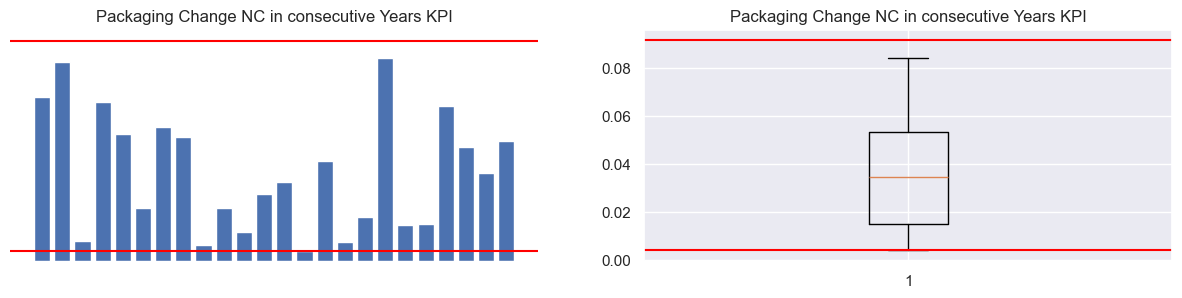

In [1101]:
pk12_2 = packaging_12

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(pk12_2.Auditor,pk12_2.ChangeInAyear)
ax1.set_title('Packaging Change NC in consecutive Years KPI')
ax1.axhline(y=UpperThreshold_pk12, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_pk12, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(packaging_12['ChangeInAyear'])
ax2.set_title('Packaging Change NC in consecutive Years KPI')
ax2.axhline(y=UpperThreshold_pk12, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_pk12, xmin=0, color = 'red')

plt.show()

In [1102]:
if 'Auditor' in packaging_12:
    packaging_12.set_index('Auditor',inplace = True)
packaging_12['Auditor'] = packaging_12.index
packaging_12 = packaging_12.rename(columns={'PercentageNC_1':'PercentajeNC_2021','PercentageNC_2':'PercentageNC_2020'})
mark_pk12 = packaging_12[(packaging_12.HighVariationNCinAYear == 1) | (packaging_12.LowVariationNCinAYear) == 1] == True
mark_pk12[['HighVariationNCinAYear','LowVariationNCinAYear']]

,HighVariationNCinAYear,LowVariationNCinAYear
Auditor,,


In [1103]:
packaging_12 = packaging_12[['Auditor','ChangeInAyear','UpperThreshold','HighVariationNCinAYear','LowerThreshold','LowVariationNCinAYear']]
#packaging_12

## Storage & Distribution Center

In [1104]:
storage_2 = df_2[df_2['AuditTemplate'].str.contains("Audit type 7", case=False)]
storage_2 = storage_2[['Auditor','PercentageNC']]
storage_2 = storage_2.groupby('Auditor').mean()
storage_1 = storage[['Auditor','PercentageNC']]
storage_1 = storage_1.reset_index(drop=True)
storage_12 = pd.merge(storage_1, storage_2, on='Auditor', suffixes=('_1', '_2'))
storage_12['ChangeInAyear'] = np.absolute(storage_12['PercentageNC_1'] - storage_12['PercentageNC_2'])
#storage_12.head()

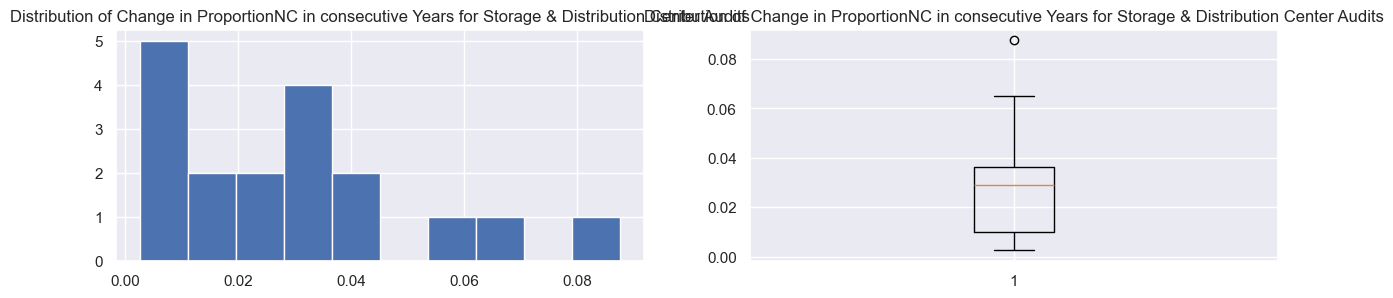

In [1105]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.hist(storage_12['ChangeInAyear'])
ax1.set_title('Distribution of Change in ProportionNC in consecutive Years for Storage & Distribution Center Audits')
ax2.boxplot(storage_12['ChangeInAyear'])
ax2.set_title('Distribution of Change in ProportionNC in consecutive Years for Storage & Distribution Center Audits')

plt.show()

### Calculating KPI

In [1106]:
mean_storage = np.mean(storage_12.ChangeInAyear)
q1_sd12 = np.percentile(storage_12.ChangeInAyear, 25)
q2_sd12 = np.percentile(storage_12.ChangeInAyear, 50)
q3_sd12 = np.percentile(storage_12.ChangeInAyear, 75)

IQR_sd12 = q3_sd12 - q1_sd12

UpperThreshold_sd12 = q3_sd12 + HighChangeinAYearNC_restriction * IQR_sd12
LowerThreshold_sd12 = q1_sd12 - LowChangeinAYearNC_restriction * IQR_sd12
if LowerThreshold_sd12 < 0:
    LowerThreshold_sd12 = storage_12['ChangeInAyear'].min()
else:
    LowerThreshold_sd12 = LowerThreshold_sd12

In [1107]:
sd12_analyzed = storage_12
sd12_analyzed['UpperThreshold'] = UpperThreshold_sd12
sd12_analyzed['HighVariationNCinAYear'] = ''
sd12_analyzed.loc[sd12_analyzed['ChangeInAyear'] > sd12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 1
sd12_analyzed.loc[sd12_analyzed['ChangeInAyear'] <= sd12_analyzed['UpperThreshold'], 'HighVariationNCinAYear'] = 0

In [1108]:
sd12_analyzed['LowVariationNCinAYear'] = ''
sd12_analyzed['LowerThreshold'] = LowerThreshold_sd12
sd12_analyzed.loc[sd12_analyzed['ChangeInAyear'] < sd12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 1
sd12_analyzed.loc[sd12_analyzed['ChangeInAyear'] >= sd12_analyzed['LowerThreshold'], 'LowVariationNCinAYear'] = 0

In [1109]:
low_sd12 = sd12_analyzed[['Auditor','LowVariationNCinAYear']]
high_sd12 = sd12_analyzed[['Auditor','HighVariationNCinAYear']]
sd12_analyzed = pd.merge(low_sd12, high_sd12, on='Auditor', suffixes=('_1', '_2'))
#sd12_analyzed.head()

### Visualization of KPI 

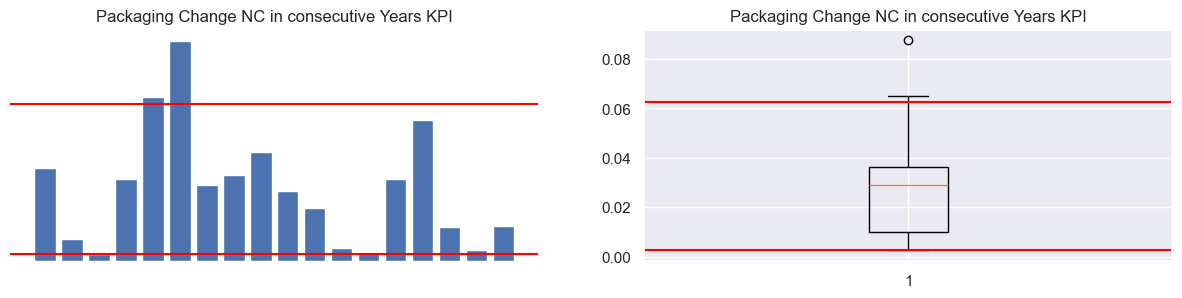

In [1110]:
sd12_2 = storage_12

f, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize= (15,3))
ax1.bar(sd12_2.Auditor,sd12_2.ChangeInAyear)
ax1.set_title('Packaging Change NC in consecutive Years KPI')
ax1.axhline(y=UpperThreshold_sd12, xmin=0, color = 'red')
ax1.axhline(y=LowerThreshold_sd12, xmin=0, color = 'red')
ax1.axis('off')
ax2.boxplot(storage_12['ChangeInAyear'])
ax2.set_title('Packaging Change NC in consecutive Years KPI')
ax2.axhline(y=UpperThreshold_sd12, xmin=0, color = 'red')
ax2.axhline(y=LowerThreshold_sd12, xmin=0, color = 'red')

plt.show()

In [1111]:
storage_12 = storage_12[['Auditor','ChangeInAyear','UpperThreshold','HighVariationNCinAYear','LowerThreshold','LowVariationNCinAYear']]
#storage_12

# Results

In [1112]:
def text_format(val):
    color = 'salmon' if val == 1 else 'white'
    return 'background-color: %s' % color

In [1113]:
pd.options.mode.chained_assignment = None  # default='warn'
auditor_CB = df[['Auditor','CBID','TpaFirmName']]
auditor_CB['id'] = auditor_CB['Auditor'] + '|' + auditor_CB['TpaFirmName']
auditor_CB = pd.DataFrame(auditor_CB['id'].unique())
auditor_CB = auditor_CB[0].str.split("|", n = 1, expand = True)
auditor_CB = auditor_CB.rename(columns={0:'Auditor',1:'CbName'})

## Proportion NC KPI

In [1114]:
greenhouse['AuditType'] = 'Audit type 1'
ranch['AuditType'] = 'Audit type 2'
cold['AuditType'] = 'Audit type 3'
harvc['AuditType'] = 'Audit type 4'
packinghouse['AuditType'] = 'Audit type 5'
packaging['AuditType'] = 'Audit type 6'
storage['AuditType'] = 'Audit type 7'
ProportionKPI = pd.concat([ranch,packaging], axis = 0)
ProportionKPI = pd.concat([ProportionKPI,storage], axis = 0)
ProportionKPI = pd.concat([ProportionKPI,greenhouse], axis = 0)
ProportionKPI = pd.concat([ProportionKPI,cold], axis = 0)
ProportionKPI = pd.concat([ProportionKPI,harvc], axis = 0)
ProportionKPI = pd.concat([ProportionKPI,packinghouse], axis = 0)
ProportionKPI = ProportionKPI.rename(columns={'PercentageNC':'ProportionNC'})
ProportionKPI = ProportionKPI[['Auditor','AuditType','ProportionNC','UpperThreshold','HighProportionNC','LowerThreshold','LowProportionNC']]
ProportionKPI = ProportionKPI.reset_index(drop=True)

ProportionKPI_CB = pd.merge(ProportionKPI, auditor_CB, on='Auditor', suffixes=('_1', '_2'))
ProportionKPI_CB = ProportionKPI_CB[ProportionKPI_CB['CbName'] == CBName]


ProportionKPI_CB.style.applymap(text_format)

/var/folders/p9/r113yjn147x6xb5hqyxkzps80000gn/T/ipykernel_27346/4046497338.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  ProportionKPI_CB.style.applymap(text_format)


,Auditor,AuditType,ProportionNC,UpperThreshold,HighProportionNC,LowerThreshold,LowProportionNC,CbName
0,Auditor 10,Audit type 2,0.021739,0.105478,0,0.005143,0,Example Auditing Firm
1,Auditor 100,Audit type 2,0.050847,0.105478,0,0.005143,0,Example Auditing Firm
2,Auditor 12,Audit type 2,0.025094,0.105478,0,0.005143,0,Example Auditing Firm
3,Auditor 13,Audit type 2,0.067797,0.105478,0,0.005143,0,Example Auditing Firm
4,Auditor 14,Audit type 2,0.105263,0.105478,0,0.005143,0,Example Auditing Firm
5,Auditor 15,Audit type 2,0.040984,0.105478,0,0.005143,0,Example Auditing Firm
6,Auditor 17,Audit type 2,0.031414,0.105478,0,0.005143,0,Example Auditing Firm
7,Auditor 18,Audit type 2,0.016760,0.105478,0,0.005143,0,Example Auditing Firm
8,Auditor 19,Audit type 2,0.053795,0.105478,0,0.005143,0,Example Auditing Firm
9,Auditor 2,Audit type 2,0.007576,0.105478,0,0.005143,0,Example Auditing Firm


## Variation Non Conformances KPI

In [1115]:
ranchSTD['AuditType'] = 'Audit type 1'
packagingSTD['AuditType'] = 'Audit type 2'
storageSTD['AuditType'] = 'Audit type 3'
greenhouseSTD['AuditType'] = 'Audit type 4'
coldSTD['AuditType'] = 'Audit type 5'
harvestSTD['AuditType'] = 'Audit type 6'
packinghouseSTD['AuditType'] = 'Audit type 7'
VariationKPI = pd.concat([ranchSTD,packagingSTD], axis = 0)
VariationKPI = pd.concat([VariationKPI,storageSTD], axis = 0)
VariationKPI = pd.concat([VariationKPI,greenhouseSTD], axis = 0)
VariationKPI = pd.concat([VariationKPI,coldSTD], axis = 0)
VariationKPI = pd.concat([VariationKPI,harvestSTD], axis = 0)
VariationKPI = pd.concat([VariationKPI,packinghouseSTD], axis = 0)
VariationKPI = VariationKPI.rename(columns={'StdNC':'VariationNC'})
VariationKPI = VariationKPI[['Auditor','AuditType','VariationNC','UpperThreshold','HighVariationNC','LowerThreshold','LowVariationNC']]
VariationKPI = VariationKPI.reset_index(drop=True)




VariationKPI_CB = pd.merge(ProportionKPI, auditor_CB, on='Auditor', suffixes=('_1', '_2'))
VariationKPI_CB = VariationKPI_CB[VariationKPI_CB['CbName'] == CBName]


VariationKPI_CB.style.applymap(text_format)

/var/folders/p9/r113yjn147x6xb5hqyxkzps80000gn/T/ipykernel_27346/3171675816.py:25: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  VariationKPI_CB.style.applymap(text_format)


,Auditor,AuditType,ProportionNC,UpperThreshold,HighProportionNC,LowerThreshold,LowProportionNC,CbName
0,Auditor 10,Audit type 2,0.021739,0.105478,0,0.005143,0,Example Auditing Firm
1,Auditor 100,Audit type 2,0.050847,0.105478,0,0.005143,0,Example Auditing Firm
2,Auditor 12,Audit type 2,0.025094,0.105478,0,0.005143,0,Example Auditing Firm
3,Auditor 13,Audit type 2,0.067797,0.105478,0,0.005143,0,Example Auditing Firm
4,Auditor 14,Audit type 2,0.105263,0.105478,0,0.005143,0,Example Auditing Firm
5,Auditor 15,Audit type 2,0.040984,0.105478,0,0.005143,0,Example Auditing Firm
6,Auditor 17,Audit type 2,0.031414,0.105478,0,0.005143,0,Example Auditing Firm
7,Auditor 18,Audit type 2,0.016760,0.105478,0,0.005143,0,Example Auditing Firm
8,Auditor 19,Audit type 2,0.053795,0.105478,0,0.005143,0,Example Auditing Firm
9,Auditor 2,Audit type 2,0.007576,0.105478,0,0.005143,0,Example Auditing Firm


## Change proportion NC in a Year KPI

In [1116]:
pd.options.mode.chained_assignment = None  # default='warn'
ranch_12['AuditType'] = 'Ranch'
packaging_12['AuditType'] = 'Packaging'
storage_12['AuditType'] = 'Storage & Distribution Center'
greenhouse_12['AuditType'] = 'Greenhouse'
cold_12['AuditType'] = 'Cooling and Cold Storage'
harv_12['AuditType'] = 'Harvest Crew'
packinghouse_12['AuditType'] = 'Packinghouse'
ChangeinAYearKPI = pd.concat([ranch_12,packaging], axis = 0)
ChangeinAYearKPI = pd.concat([ChangeinAYearKPI,storage_12], axis = 0)
ChangeinAYearKPI = pd.concat([ChangeinAYearKPI,greenhouse_12], axis = 0)
ChangeinAYearKPI = pd.concat([ChangeinAYearKPI,cold_12], axis = 0)
ChangeinAYearKPI = pd.concat([ChangeinAYearKPI,harv_12], axis = 0)
ChangeinAYearKPI = pd.concat([ChangeinAYearKPI,packinghouse_12], axis = 0)
ChangeinAYearKPI = ChangeinAYearKPI.rename(columns={'PercentageNC':'ProportionNC'})
ChangeinAYearKPI = ChangeinAYearKPI[['Auditor','AuditType','ChangeInAyear','UpperThreshold','HighVariationNCinAYear','LowerThreshold','LowVariationNCinAYear']]
ChangeinAYearKPI = ChangeinAYearKPI.reset_index(drop=True)
ChangeinAYearKPI = ChangeinAYearKPI.dropna()


ChangeinAYearKPI_CB = pd.merge(ProportionKPI, auditor_CB, on='Auditor', suffixes=('_1', '_2'))
ChangeinAYearKPI_CB = ChangeinAYearKPI_CB[ChangeinAYearKPI_CB['CbName'] == CBName]


ChangeinAYearKPI_CB.style.applymap(text_format)

/var/folders/p9/r113yjn147x6xb5hqyxkzps80000gn/T/ipykernel_27346/1729764523.py:25: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  ChangeinAYearKPI_CB.style.applymap(text_format)


,Auditor,AuditType,ProportionNC,UpperThreshold,HighProportionNC,LowerThreshold,LowProportionNC,CbName
0,Auditor 10,Audit type 2,0.021739,0.105478,0,0.005143,0,Example Auditing Firm
1,Auditor 100,Audit type 2,0.050847,0.105478,0,0.005143,0,Example Auditing Firm
2,Auditor 12,Audit type 2,0.025094,0.105478,0,0.005143,0,Example Auditing Firm
3,Auditor 13,Audit type 2,0.067797,0.105478,0,0.005143,0,Example Auditing Firm
4,Auditor 14,Audit type 2,0.105263,0.105478,0,0.005143,0,Example Auditing Firm
5,Auditor 15,Audit type 2,0.040984,0.105478,0,0.005143,0,Example Auditing Firm
6,Auditor 17,Audit type 2,0.031414,0.105478,0,0.005143,0,Example Auditing Firm
7,Auditor 18,Audit type 2,0.016760,0.105478,0,0.005143,0,Example Auditing Firm
8,Auditor 19,Audit type 2,0.053795,0.105478,0,0.005143,0,Example Auditing Firm
9,Auditor 2,Audit type 2,0.007576,0.105478,0,0.005143,0,Example Auditing Firm


# Generate Excel Files

In [1117]:
ProportionKPI = pd.merge(ProportionKPI, auditor_CB, on='Auditor', suffixes=('_1', '_2'))

In [1118]:
ProportionKPI['FlagAuditor_ProportionNC'] = ProportionKPI['HighProportionNC'] + ProportionKPI['LowProportionNC']

In [1119]:
if 'CbName_1' in ProportionKPI.columns:
    del(ProportionKPI['CbName_1'])

if 'CbName_2' in ProportionKPI.columns:
    del(ProportionKPI['CbName_2'])
    
if 'HighProportionNC' in ProportionKPI.columns:
    del(ProportionKPI['HighProportionNC'])
    
if 'LowProportionNC' in ProportionKPI.columns:
    del(ProportionKPI['LowProportionNC'])

In [1120]:
if 'CbName' in ProportionKPI.columns:
    ProportionKPI.head()
else:
    ProportionKPI = pd.merge(ProportionKPI, auditor_CB, on='Auditor', suffixes=('_1', '_2'))



In [1121]:
VariationKPI = pd.merge(VariationKPI, auditor_CB, on='Auditor', suffixes=('_1', '_2'))

In [1122]:
if 'HighVariationNC' in ProportionKPI.columns:
    VariationKPI['FlagAuditor_VariationNC'] = VariationKPI['HighVariationNC'] + VariationKPI['LowVariationNC']

In [1123]:
if 'CbName_1' in VariationKPI.columns:
    del(VariationKPI['CbName_1'])

if 'CbName_2' in VariationKPI.columns:
    del(VariationKPI['CbName_2'])
    
if 'HighVariationNC' in VariationKPI.columns:
    del(VariationKPI['HighVariationNC'])
    
if 'LowVariationNC' in VariationKPI.columns:
    del(VariationKPI['LowVariationNC'])

In [1124]:
if 'CbName' in VariationKPI.columns:
    VariationKPI.head()
else:
    VariationKPI = pd.merge(VariationKPI, auditor_CB, on='Auditor', suffixes=('_1', '_2'))
    VariationKPI.head()


In [1125]:
ChangeinAYearKPI = pd.merge(ChangeinAYearKPI, auditor_CB, on='Auditor', suffixes=('_1', '_2'))

In [1126]:
if 'HighVariationNCinAYear' in ChangeinAYearKPI.columns:
    ChangeinAYearKPI['FlagAuditor_VariationNCinAYear'] = ChangeinAYearKPI['HighVariationNCinAYear'] + ChangeinAYearKPI['LowVariationNCinAYear']

In [1127]:
if 'CbName_1' in ChangeinAYearKPI.columns:
    del(ChangeinAYearKPI['CbName_1'])

if 'CbName_2' in ChangeinAYearKPI.columns:
    del(ChangeinAYearKPI['CbName_2'])
    
if 'HighVariationNCinAYear' in ChangeinAYearKPI.columns:
    del(ChangeinAYearKPI['HighVariationNCinAYear'])
    
if 'LowVariationNCinAYear' in ChangeinAYearKPI.columns:
    del(ChangeinAYearKPI['LowVariationNCinAYear'])

In [1128]:
if 'CbName' in ChangeinAYearKPI.columns:
    ChangeinAYearKPI.head()
else:
    ChangeinAYearKPI = pd.merge(ChangeinAYearKPI, auditor_CB, on='Auditor', suffixes=('_1', '_2'))
    ChangeinAYearKPI.head()

ChangeinAYearKPI = ChangeinAYearKPI[['Auditor','AuditType','ChangeInAyear','UpperThreshold','LowerThreshold','FlagAuditor_VariationNCinAYear','CbName']]

In [1129]:
ProportionKPI.head()

,Auditor,AuditType,ProportionNC,UpperThreshold,LowerThreshold,CbName,FlagAuditor_ProportionNC
0,Auditor 10,Audit type 2,0.021739,0.105478,0.005143,Example Auditing Firm,0
1,Auditor 100,Audit type 2,0.050847,0.105478,0.005143,Example Auditing Firm,0
2,Auditor 12,Audit type 2,0.025094,0.105478,0.005143,Example Auditing Firm,0
3,Auditor 13,Audit type 2,0.067797,0.105478,0.005143,Example Auditing Firm,0
4,Auditor 14,Audit type 2,0.105263,0.105478,0.005143,Example Auditing Firm,0


In [1130]:
VariationKPI.head()

,Auditor,AuditType,VariationNC,UpperThreshold,LowerThreshold,CbName
0,Auditor 12,Audit type 1,0.012048,0.053055,0.000153,Example Auditing Firm
1,Auditor 19,Audit type 1,0.016657,0.053055,0.000153,Example Auditing Firm
2,Auditor 25,Audit type 1,0.038535,0.053055,0.000153,Example Auditing Firm
3,Auditor 33,Audit type 1,0.005660,0.053055,0.000153,Example Auditing Firm
4,Auditor 36,Audit type 1,0.031769,0.053055,0.000153,Example Auditing Firm


In [1131]:
ChangeinAYearKPI.head()

,Auditor,AuditType,ChangeInAyear,UpperThreshold,LowerThreshold,FlagAuditor_VariationNCinAYear,CbName
0,Auditor 100,Ranch,0.003045,0.06888,0.001852,0,Example Auditing Firm
1,Auditor 17,Ranch,0.022884,0.06888,0.001852,0,Example Auditing Firm
2,Auditor 24,Ranch,0.005803,0.06888,0.001852,0,Example Auditing Firm
3,Auditor 25,Ranch,0.005515,0.06888,0.001852,0,Example Auditing Firm
4,Auditor 27,Ranch,0.028782,0.06888,0.001852,0,Example Auditing Firm


## Audit Examples

In [1132]:
ProportionKPI_CB = ProportionKPI[ProportionKPI['CbName'] == 'Primus Auditing Ops (PAO)']
VariationKPI_CB = VariationKPI[VariationKPI['CbName'] == 'Primus Auditing Ops (PAO)']
ChangeinAYearKPI_CB = ChangeinAYearKPI[ChangeinAYearKPI['CbName'] == 'Primus Auditing Ops (PAO)']

In [1133]:
if save_to_excel == 1:
    with pd.ExcelWriter('path/excel.xlsx') as writer:
        ProportionKPI_CB.to_excel(writer, sheet_name='ProportionNC_KPI')
        VariationKPI_CB.to_excel(writer, sheet_name='VariationNC_KPI')
        ChangeinAYearKPI_CB.to_excel(writer, sheet_name='ChangeInAYear_KPI')

## SCS Global Services

In [1134]:
ProportionKPI_CB = ProportionKPI[ProportionKPI['CbName'] == 'SCS Global Services']
VariationKPI_CB = VariationKPI[VariationKPI['CbName'] == 'SCS Global Services']
ChangeinAYearKPI_CB = ChangeinAYearKPI[ChangeinAYearKPI['CbName'] == 'SCS Global Services']

In [1135]:
if save_to_excel == 1:
    with pd.ExcelWriter('path/excel.xlsx') as writer:
        ProportionKPI_CB.to_excel(writer, sheet_name='ProportionNC_KPI')
        VariationKPI_CB.to_excel(writer, sheet_name='VariationNC_KPI')
        ChangeinAYearKPI_CB.to_excel(writer, sheet_name='ChangeInAYear_KPI')

## WQS, LLC

In [1136]:
ProportionKPI_CB = ProportionKPI[ProportionKPI['CbName'] == 'WQS, LLC']
VariationKPI_CB = VariationKPI[VariationKPI['CbName'] == 'WQS, LLC']
ChangeinAYearKPI_CB = ChangeinAYearKPI[ChangeinAYearKPI['CbName'] == 'WQS, LLC']

In [1137]:
if save_to_excel == 1:
    with pd.ExcelWriter('path/excel.xlsx') as writer:
        ProportionKPI_CB.to_excel(writer, sheet_name='ProportionNC_KPI')
        VariationKPI_CB.to_excel(writer, sheet_name='VariationNC_KPI')
        ChangeinAYearKPI_CB.to_excel(writer, sheet_name='ChangeInAYear_KPI')

## Ceres Certification International

In [1138]:
ProportionKPI_CB = ProportionKPI[ProportionKPI['CbName'] == 'Ceres Certification International']
VariationKPI_CB = VariationKPI[VariationKPI['CbName'] == 'Ceres Certification International']
ChangeinAYearKPI_CB = ChangeinAYearKPI[ChangeinAYearKPI['CbName'] == 'Ceres Certification International']

In [1139]:
if save_to_excel == 1:
    with pd.ExcelWriter('path/excel.xlsx') as writer:
        ProportionKPI_CB.to_excel(writer, sheet_name='ProportionNC_KPI')
        VariationKPI_CB.to_excel(writer, sheet_name='VariationNC_KPI')
        ChangeinAYearKPI_CB.to_excel(writer, sheet_name='ChangeInAYear_KPI')

## Food Safety Certifiers

In [1140]:
ProportionKPI_CB = ProportionKPI[ProportionKPI['CbName'] == 'Food Safety Certifiers']
VariationKPI_CB = VariationKPI[VariationKPI['CbName'] == 'Food Safety Certifiers']
ChangeinAYearKPI_CB = ChangeinAYearKPI[ChangeinAYearKPI['CbName'] == 'Food Safety Certifiers']

In [1141]:
if save_to_excel == 1:
    with pd.ExcelWriter('path/excel.xlsx') as writer:
        ProportionKPI_CB.to_excel(writer, sheet_name='ProportionNC_KPI')
        VariationKPI_CB.to_excel(writer, sheet_name='VariationNC_KPI')
        ChangeinAYearKPI_CB.to_excel(writer, sheet_name='ChangeInAYear_KPI')

## Control Union Certification

In [1142]:
ProportionKPI_CB = ProportionKPI[ProportionKPI['CbName'] == 'Control Union Certification']
VariationKPI_CB = VariationKPI[VariationKPI['CbName'] == 'Control Union Certification']
ChangeinAYearKPI_CB = ChangeinAYearKPI[ChangeinAYearKPI['CbName'] == 'Control Union Certification']

In [1143]:
if save_to_excel == 1:
    with pd.ExcelWriter('path/excel.xlsx') as writer:
        ProportionKPI_CB.to_excel(writer, sheet_name='ProportionNC_KPI')
        VariationKPI_CB.to_excel(writer, sheet_name='VariationNC_KPI')
        ChangeinAYearKPI_CB.to_excel(writer, sheet_name='ChangeInAYear_KPI')

## NSF Certification, LLC

In [1144]:
ProportionKPI_CB = ProportionKPI[ProportionKPI['CbName'] == 'NSF Certification, LLC']
VariationKPI_CB = VariationKPI[VariationKPI['CbName'] == 'NSF Certification, LLC']
ChangeinAYearKPI_CB = ChangeinAYearKPI[ChangeinAYearKPI['CbName'] == 'NSF Certification, LLC']

In [1145]:
if save_to_excel == 1:
    with pd.ExcelWriter('path/excel.xlsx') as writer:
        ProportionKPI_CB.to_excel(writer, sheet_name='ProportionNC_KPI')
        VariationKPI_CB.to_excel(writer, sheet_name='VariationNC_KPI')
        ChangeinAYearKPI_CB.to_excel(writer, sheet_name='ChangeInAYear_KPI')

## Professional Food Safety

In [1146]:
ProportionKPI_CB = ProportionKPI[ProportionKPI['CbName'] == 'Professional Food Safety']
VariationKPI_CB = VariationKPI[VariationKPI['CbName'] == 'Professional Food Safety']
ChangeinAYearKPI_CB = ChangeinAYearKPI[ChangeinAYearKPI['CbName'] == 'Professional Food Safety']

In [1147]:
if save_to_excel == 1:
    with pd.ExcelWriter('path/excel.xlsx') as writer:
        ProportionKPI_CB.to_excel(writer, sheet_name='ProportionNC_KPI')
        VariationKPI_CB.to_excel(writer, sheet_name='VariationNC_KPI')
        ChangeinAYearKPI_CB.to_excel(writer, sheet_name='ChangeInAYear_KPI')

In [1148]:
print('Finished')

Finished
